# 6장 추천엔진 만들기 

데이터: [Anime Recommendation Database 2020](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv)

## 바이인코더와 크로스인코더 비교

Q: 바이인코더와 크로스인코더를 비교해줘

A: 바이인코더와 크로스 인코더는 자연어 처리에서 문장 쌍의 관계를 모델링하는 데 사용되는 두 가지 주요 아키텍처입니다. 다음은 두 아키텍처의 비교입니다:

1. 구조 및 동작 방식:
- 바이인코더: 두 개의 독립적인 인코더를 사용하여 각 문장을 별도로 처리합니다. 인코딩된 벡터 사이의 유사도를 계산하여 문장 쌍의 관계를 판단합니다.
- 크로스 인코더: 두 문장을 하나의 시퀀스로 연결하여 단일 인코더에 전달합니다. 인코더의 출력을 기반으로 문장 쌍의 관계를 예측하는 분류기를 사용합니다.

2. 추론 속도:
- 바이인코더: 각 문장을 독립적으로 인코딩하므로 추론 속도가 빠릅니다. 대규모 코퍼스에 대한 유사도 계산이 효율적입니다.
- 크로스 인코더: 각 문장 쌍마다 인코더를 통과해야 하므로 추론 속도가 상대적으로 느립니다. 대규모 코퍼스에 대한 유사도 계산은 비효율적일 수 있습니다.

3. 정확도:
- 바이인코더: 문장 간 상호작용을 직접 모델링하지 않으므로, 정확도가 크로스 인코더에 비해 다소 낮을 수 있습니다.
- 크로스 인코더: 문장 간 상호작용을 직접 모델링하므로, 문장 쌍의 관계를 보다 정확하게 예측할 수 있습니다.

4. 메모리 사용량:
- 바이인코더: 각 문장에 대한 임베딩 벡터를 저장해야 하므로, 메모리 사용량이 크로스 인코더에 비해 높을 수 있습니다.
- 크로스 인코더: 각 문장 쌍을 개별적으로 처리하므로, 메모리 사용량이 바이인코더에 비해 낮습니다.

5. 적용 분야:
- 바이인코더: 대규모 코퍼스에 대한 유사도 계산, 의미 검색, 개체명 연결 등의 태스크에 적합합니다.
- 크로스 인코더: 문장 쌍의 관계를 보다 정확하게 예측해야 하는 태스크(예: 자연어 추론, 의미 유사도 계산)에 적합합니다.

두 아키텍처는 각각의 장단점이 있으므로, 태스크의 특성과 요구 사항에 따라 적절한 아키텍처를 선택해야 합니다. 경우에 따라서는 두 아키텍처를 조합하여 사용하기도 합니다. 예를 들어, 바이인코더를 사용하여 후보 문장을 필터링한 후, 크로스 인코더를 사용하여 최종 순위를 결정하는 방식 등이 있습니다.

# 1. 데이터 로딩

## 1.1 애니메이션 정보 데이터 로딩

In [1]:
import pandas as pd

In [2]:
pre_merged_anime = pd.read_csv('../data/pre_merged_anime.csv').dropna()
print(pre_merged_anime.shape)
pre_merged_anime.head(2)

(16206, 19)


,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."


In [3]:
import re
import string

def clean_text(text):
    # 인쇄할 수 없는 문자 제거
    text = ''.join(filter(lambda x: x in string.printable, text))
    
    # 여러 개의 공백 문자를 하나의 공백으로 바꾸기
    text = re.sub(r'\s{2,}', ' ', text).strip()

    return text.strip()


def get_anime_description(anime_row):
    """
    입력 데이터의 다양한 기능을 기반으로 애니메이션 제목에 대한 사용자 지정 설명을 생성합니다.

    :param anime_row: 관련 애니메이션 정보가 포함된 MyAnimeList 데이터 세트의 행입니다.
    :return: 애니메이션에 대한 사용자 지정 설명이 포함된 형식화된 문자열입니다.
    """

    # 애니메이션 유형(TV 프로그램 또는 기타)을 결정합니다.
    anime_type = "TV Show" if anime_row["Type"] == "TV" else anime_row["Type"]

    # 입력 데이터의 관련 기능을 사용하여 형식이 지정된 설명을 작성합니다.
    description = (
        f"{anime_row['Name']} is a {anime_type}.\n"
        f"Synopsis: {anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']} and it is from {anime_row['Studios']} Studio.\n"
        f"Its source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}.\n"
        f"Its genres are {anime_row['Genres']}\n"
    )

    return clean_text(description)


In [4]:
print(clean_text(get_anime_description(pre_merged_anime.iloc[0])))

Cowboy Bebop is a TV Show.
Synopsis: In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Be

get_anime_description() 실행 결과를 generated_description 항목에 저장

In [5]:
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis=1)

In [6]:
pre_merged_anime

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis,generated_description
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever...",Cowboy Bebop is a TV Show.\nSynopsis: In the y...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ...",Cowboy Bebop: Tengoku no Tobira is a Movie.\nS...
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,26,Spring 1998,Victor Entertainment,Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,558913,12944,343492,25465,"Vash the Stampede is the man with a $$60,000,0...",Trigun is a TV Show.\nSynopsis: Vash the Stamp...
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,TV,26,Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,94683,587,46165,5121,ches are individuals with special powers like ...,Witch Hunter Robin is a TV Show.\nSynopsis: ch...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,52,Fall 2004,"TV Tokyo, Dentsu",Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,13224,18,7314,766,It is the dark century and the people are suff...,Bouken Ou Beet is a TV Show.\nSynopsis: It is ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16201,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,ONA,Unknown,Unknown,Unknown,Unknown,Novel,Unknown,Unknown,Unknown,354,6,0,0,No synopsis information has been added to this...,Daomu Biji Zhi Qinling Shen Shu is a ONA.\nSyn...
16202,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,TV,Unknown,Unknown,Kadokawa,Passione,Manga,Unknown,Unknown,Unknown,7010,70,0,14,ko is a typical high school student whose life...,Mieruko-chan is a TV Show.\nSynopsis: ko is a ...
16203,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,TV,Unknown,Summer 2021,Unknown,Unknown,Visual novel,Unknown,R - 17+ (violence & profanity),Unknown,11309,48,0,0,Sequel to Higurashi no Naku Koro ni Gou .,Higurashi no Naku Koro ni Sotsu is a TV Show.\...
16204,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",Unknown,TV,Unknown,Unknown,Kadokawa,8bit,Manga,Unknown,PG-13 - Teens 13 or older,Unknown,1386,2,2,2,New Yama no Susume anime.,Yama no Susume: Next Summit is a TV Show.\nSyn...


## 1.2 시청 상태 코드 데이터 로딩

In [7]:
watching_status = pd.read_csv('../data/anime/watching_status.csv').dropna()
print(watching_status.shape)
watching_status

(5, 2)


,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


## 1.3 평점 데이터 로딩
user_id, anime_id, rating

In [8]:
rating_complete = pd.read_csv('../data/anime/rating_complete.csv').dropna()
print(rating_complete.shape)

(57633278, 3)


In [9]:
rating_complete.head(20)

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
5,0,431,8
6,0,578,10
7,0,433,6
8,0,1571,10
9,0,121,9


## 1.4 평점 데이터 분할
`rating_complete` 데이터를 훈련 세트와 테스트 세트로 분할하는 역할을 합니다. 자세한 설명은 다음과 같습니다:

1. `rating_complete.sample(frac=1, random_state=42)`은 `rating_complete` 데이터프레임을 무작위로 섞습니다.
   - `frac=1`은 전체 데이터프레임을 샘플링한다는 의미입니다. 즉, 데이터프레임의 모든 행을 포함합니다.
   - `random_state=42`는 무작위 섞기의 시드(seed) 값을 설정합니다. 이렇게 하면 코드를 다시 실행해도 동일한 결과를 얻을 수 있습니다.

2. `int(.9*len(rating_complete))`은 전체 데이터의 90%에 해당하는 인덱스를 계산합니다.
   - `len(rating_complete)`은 `rating_complete` 데이터프레임의 총 행 수를 반환합니다.
   - `.9`를 곱하여 전체 데이터의 90%에 해당하는 개수를 계산합니다.
   - `int()`로 감싸서 정수로 변환합니다.

3. `np.split(rating_complete.sample(frac=1, random_state=42), [int(.9*len(rating_complete))])`은 섞인 데이터프레임을 90%와 10%로 분할합니다.
   - `np.split()` 함수는 첫 번째 인자로 분할할 배열 또는 데이터프레임을 받고, 두 번째 인자로 분할 지점을 리스트 형태로 받습니다.
   - `[int(.9*len(rating_complete))]`은 전체 데이터의 90%에 해당하는 인덱스를 리스트로 전달합니다.
   - 이렇게 하면 `np.split()` 함수는 섞인 데이터프레임을 90%와 10%로 분할하여 두 개의 데이터프레임을 반환합니다.

4. 분할된 두 개의 데이터프레임은 `rating_complete_train`과 `rating_complete_test` 변수에 할당됩니다.
   - `rating_complete_train`은 전체 데이터의 90%를 포함하는 훈련 세트가 됩니다.
   - `rating_complete_test`는 전체 데이터의 나머지 10%를 포함하는 테스트 세트가 됩니다.

이 코드는 데이터를 무작위로 섞은 후, 훈련 세트와 테스트 세트로 분할하는 일반적인 데이터 분할 방법을 구현한 것입니다. 훈련 세트는 모델을 학습시키는 데 사용되고, 테스트 세트는 학습된 모델의 성능을 평가하는 데 사용됩니다. 일반적으로 훈련 세트와 테스트 세트의 비율은 8:2 또는 9:1로 설정하며, 이 코드에서는 9:1의 비율로 분할하고 있습니다.

In [10]:
import numpy as np

rating_complete_train, rating_complete_test = \
              np.split(rating_complete.sample(frac=1, random_state=42), 
                       [int(.9*len(rating_complete))])

/Users/wlkim/anaconda3/envs/quick-start-guide-to-llms/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
rating_complete_train.head()

,user_id,anime_id,rating
41605545,255419,4059,7
33600014,206382,10793,7
39884414,245012,34246,4
45251042,277697,5030,7
53777062,329602,227,7


In [12]:
rating_complete_test.head()

,user_id,anime_id,rating
57039029,349749,154,9
33418394,205282,18001,9
18511337,113697,10110,9
53862736,330116,37520,7
30501411,187612,209,10


In [13]:
print(rating_complete_train.shape)
print(rating_complete_test.shape)

(51869950, 3)
(5763328, 3)


## 1.5 평점 데이터 분석

In [14]:
rating_complete_train.describe()

,user_id,anime_id,rating
count,5.186995e+07,5.186995e+07,5.186995e+07
mean,1.768898e+05,1.583165e+04,7.510736e+00
std,1.020080e+05,1.326141e+04,1.697711e+00
min,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.828800e+04,3.091000e+03,7.000000e+00
50%,1.772940e+05,1.188700e+04,8.000000e+00
75%,2.654180e+05,2.899900e+04,9.000000e+00
max,3.534040e+05,4.845600e+04,1.000000e+01


<Axes: >

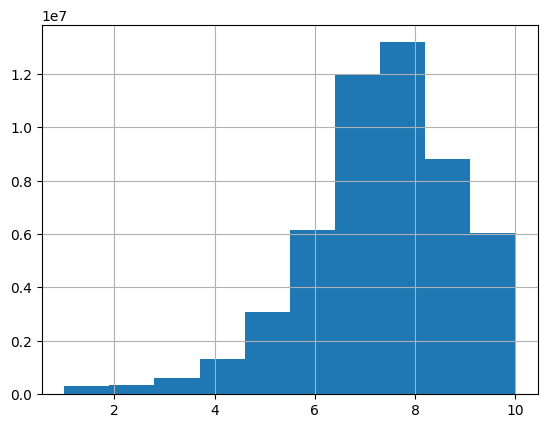

In [15]:
rating_complete_train["rating"].hist()

<Axes: >

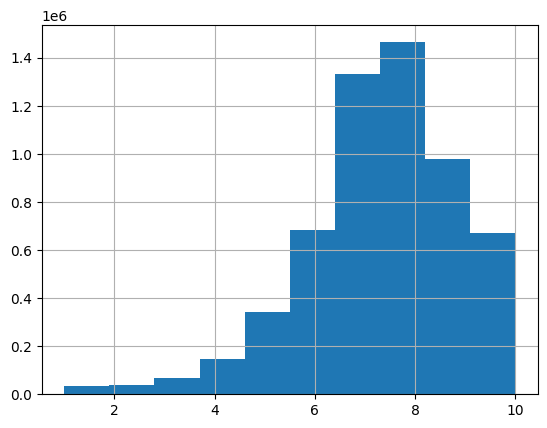

In [16]:
rating_complete_test["rating"].hist()

## 1.6 anime_id별 평가 수 계산

In [17]:
rating_complete_train

,user_id,anime_id,rating
41605545,255419,4059,7
33600014,206382,10793,7
39884414,245012,34246,4
45251042,277697,5030,7
53777062,329602,227,7
...,...,...,...
412873,2622,34494,7
40307673,247653,14741,5
13521966,82846,133,5
5162500,31656,242,8


In [18]:
rating_complete_train.groupby('anime_id').count()

,user_id,rating
anime_id,,
1,71791,71791
5,30094,30094
6,42315,42315
7,9215,9215
8,1371,1371
...,...,...
47614,55,55
47616,1584,1584
47618,15,15


In [19]:
# 데이터 프레임을 anime_id로 그룹화하고 각 애니메이션에 해당하는 행 수를 계산합니다.
anime_counts = rating_complete_train.groupby('anime_id').count()

anime_counts['user_id'].describe()

count     16865.000000
mean       3075.597391
std        9275.477582
min           1.000000
25%          36.000000
50%         240.000000
75%        1506.000000
max      164244.000000
Name: user_id, dtype: float64

In [20]:
anime_counts

,user_id,rating
anime_id,,
1,71791,71791
5,30094,30094
6,42315,42315
7,9215,9215
8,1371,1371
...,...,...
47614,55,55
47616,1584,1584
47618,15,15


In [21]:
anime_counts.describe()

,user_id,rating
count,16865.000000,16865.000000
mean,3075.597391,3075.597391
std,9275.477582,9275.477582
min,1.000000,1.000000
25%,36.000000,36.000000
50%,240.000000,240.000000
75%,1506.000000,1506.000000
max,164244.000000,164244.000000


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'rating'}>]], dtype=object)

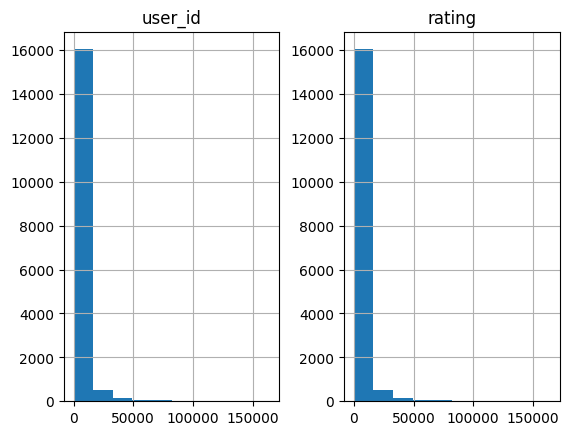

In [22]:
anime_counts.hist()

## 1.7 user_id별 평가 수 계산

In [23]:
# 데이터 프레임을 user_id로 그룹화하고 각 애니메이션에 해당하는 행 수를 계산합니다.
user_counts = rating_complete_train.groupby('user_id').count()

user_counts['anime_id'].describe()

count    309426.000000
mean        167.632810
std         229.910583
min           1.000000
25%          39.000000
50%         102.000000
75%         214.000000
max       13955.000000
Name: anime_id, dtype: float64

In [24]:
user_counts

,anime_id,rating
user_id,,
0,32,32
1,93,93
2,47,47
3,276,276
4,97,97
...,...,...
353400,62,62
353401,54,54
353402,19,19


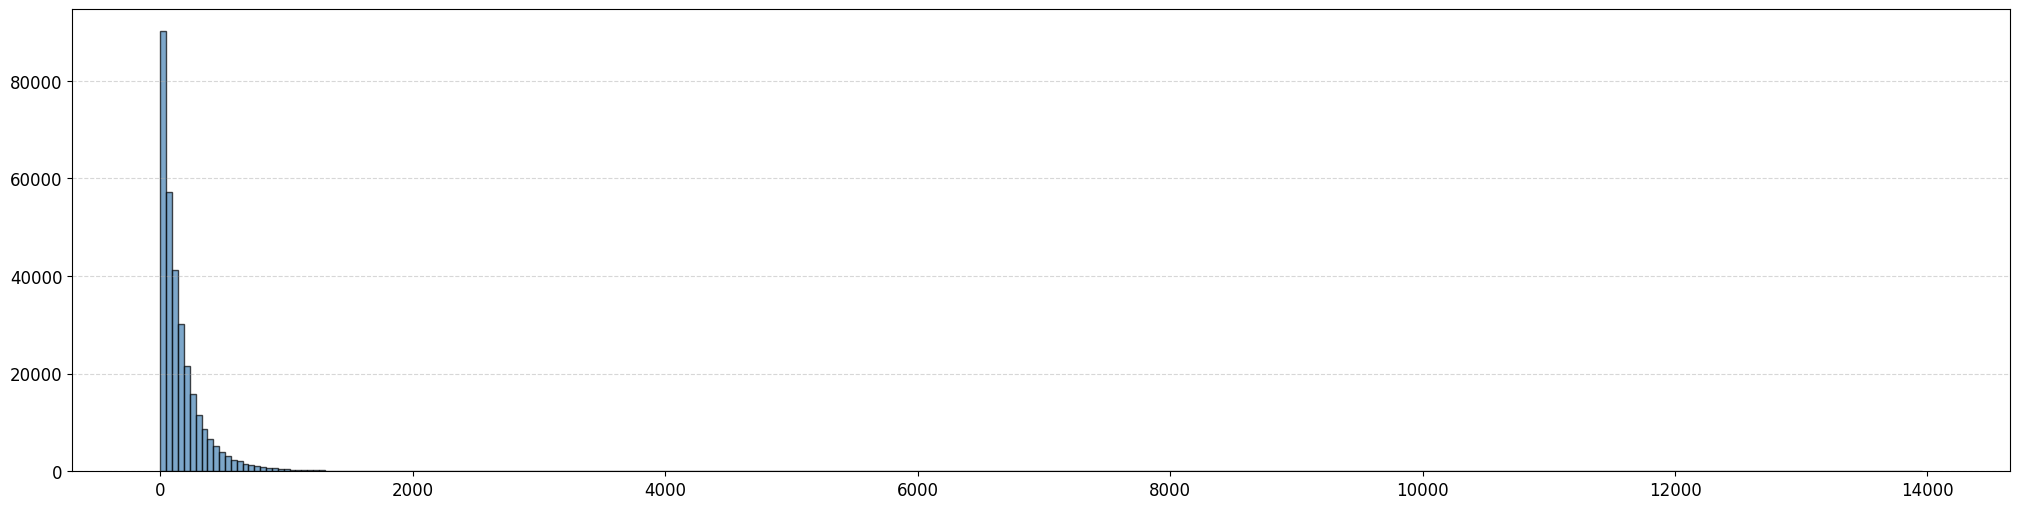

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 플롯과 히스토그램 설정
plt.figure(figsize=(25, 6))
plt.hist(user_counts['anime_id'], bins=300, edgecolor='black', color='steelblue', alpha=0.7)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')

# 히스토그램 표시
plt.show()

# 2. 콘텐츠 임베딩을 사용하여 타이틀 추천하기

In [26]:
!pip install dask dask-ml

## 2.1 초기화, 자카드 유사도 함수 정의

In [27]:
# 데이터 분포를 고려하여 9, 10의 경우 긍정(1) 7, 8의 경우 중립(0) 나머지는 부정(-1)으로 구성
score_map = {10: 1, 9: 1, 8: 0, 7: 0, 6: -1, 5: -1, 4:-1, 3:-1, 2:-1, 1:-1, 0:-1}

In [28]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [29]:
import pandas as pd
import itertools
import random

# 자카드 유사도 = 교집합 / 합집합
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union:
        return intersection / union

아래 코드는 애니메이션 데이터와 평점 데이터를 사용하여 긍정적인 평가를 필터링하고, 애니메이션 쌍을 생성하는 과정입니다. 코드의 각 부분을 자세히 설명하겠습니다:

1. 긍정적인 예시에 대한 평점 임계값 설정:
   ```python
   rating_threshold = 9
   ```
   - `rating_threshold` 변수는 긍정적인 평가로 간주할 평점의 임계값을 설정합니다.
   - 여기서는 9점 이상의 평점을 긍정적인 평가로 간주합니다.

2. 긍정적 평가 필터링:
   ```python
   positive_ratings = rating_complete_train[rating_complete_train['rating'] >= rating_threshold]
   ```
   - `rating_complete_train` 데이터프레임에서 `'rating'` 열의 값이 `rating_threshold` 이상인 행만 선택하여 `positive_ratings` 데이터프레임을 생성합니다.
   - 이를 통해 긍정적인 평가만 필터링됩니다.

3. 사용자별 긍정적으로 평가된 애니메이션 사전 생성:
   ```python
   user_anime_dict = positive_ratings.groupby('user_id')['anime_id'].apply(set).to_dict()
   ```
   - `positive_ratings` 데이터프레임을 `'user_id'` 열로 그룹화한 후, `'anime_id'` 열의 값을 집합(set)으로 변환하여 사전(dictionary)으로 만듭니다.
   - 이렇게 생성된 `user_anime_dict` 사전은 각 사용자(`'user_id'`)가 긍정적으로 평가한 애니메이션(`'anime_id'`)의 집합을 값으로 갖습니다.

4. 두 데이터프레임의 교집합 추출:
   ```python
   set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique())
   ```
   - `pre_merged_anime` 데이터프레임의 `'MAL_ID'` 열과 `rating_complete_train` 데이터프레임의 `'anime_id'` 열에서 고유한 값들의 집합을 각각 생성합니다.
   - 두 집합의 교집합을 구하여 두 데이터프레임에 공통으로 존재하는 애니메이션의 ID를 추출합니다.

5. 애니메이션 쌍 생성:
   ```python
   anime_pairs = itertools.combinations(sorted(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique())), 2)
   ```
   - `itertools.combinations()` 함수를 사용하여 두 데이터프레임의 교집합에 속하는 애니메이션 ID 중에서 2개씩 조합을 생성합니다.
   - 생성된 조합은 `anime_pairs` 변수에 이터레이터 형태로 저장됩니다.

이 코드는 애니메이션 데이터와 평점 데이터를 활용하여 긍정적인 평가를 필터링하고, 사용자별로 긍정적으로 평가한 애니메이션의 집합을 생성합니다. 또한, 두 데이터프레임에 공통으로 존재하는 애니메이션 ID를 추출하고, 그 중에서 2개씩 조합을 생성하여 애니메이션 쌍을 만듭니다.

이렇게 생성된 애니메이션 쌍은 추천 시스템이나 유사도 분석 등의 작업에 활용될 수 있습니다.

In [30]:
# 긍정적인 예시에 대한 평점 임계값 설정하기
rating_threshold = 9

# 긍정적 평가 필터링
positive_ratings = rating_complete_train[rating_complete_train['rating'] >= rating_threshold]

# user_id와 긍정적으로 평가된 애니메이션의 사전을 만듭니다.
user_anime_dict = positive_ratings.groupby('user_id')['anime_id'].apply(set).to_dict()


# set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique() : 두 데이터 프레임의 교집합 추출 (총 15542개) 즉 애니메이션 목록에 있으면서 평가 데이터도 존재
# itertools.combinations : 조합(combination) 연산 후 이터레이터 형태로 반환 (15542 * 15541 / 2 = 120769111)
anime_pairs = itertools.combinations(sorted(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique())), 2)

In [31]:
len(set(pre_merged_anime['MAL_ID'].unique()))

16206

In [32]:
len(set(rating_complete_train['anime_id'].unique()))

16865

In [33]:
len(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique()))

15542

In [34]:
len(sorted(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique())))

15542

In [35]:
result = list(itertools.combinations(sorted(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique())), 2))
print(len(result))
print(result[0])
print(result[1])

120769111
(1, 5)
(1, 6)


## 2.2 자카트 유사도를 이용한 긍정/부정 데이터 판별 및 데이터 생성

In [36]:
'''
이 스크립트는 각 예제가 한 쌍의 애니메이션으로 구성된 훈련 예제를 준비합니다. 
각 쌍에 대한 레이블은 쌍에 포함된 각 애니메이션을 좋아하는 사용자의 
애니메이션을 좋아하는 사용자의 자카드 유사도를 기반으로 합니다. Jaccard 유사도(>= 0.3)가 높으면 해당 애니메이션이 
애니메이션이 유사하다는 것을 의미하며(긍정적인 예), 낮은 Jaccard 유사도(<0.1)는 
애니메이션이 서로 다르다는 것을 의미합니다(부정적인 예시). 

스크립트는 각 긍정적 예시당 최대 5개의 부정적 예시 비율을 유지합니다.
'''
# 필요한 라이브러리 가져오기
from random import sample, seed
from sentence_transformers import InputExample

# 양수 및 음수 쌍 예제를 저장하기 위한 빈 목록 초기화하기
positive_pairs_examples, negative_pairs_examples = [], []

# 결과의 재현성을 보장하기 위해 랜덤 함수의 시드 값을 설정합니다.
seed(42)

# 각 애니메이션 쌍 반복
for a1, a2 in tqdm(anime_pairs):
    # 쌍의 애니메이션 중 하나라도 pre_merged_anime 데이터프레임 인덱스에서 찾을 수 없는 경우 현재 반복을 건너뜁니다.
    if a1 not in pre_merged_anime.index or a2 not in pre_merged_anime.index:
        continue

    # 애니메이션 a1과 애니메이션 a2를 좋아하는 사용자 집합 간의 Jaccard 유사도 계산하기
    j = jaccard_similarity(user_anime_dict.get(a1, set()), user_anime_dict.get(a2, set())) 

    # Jaccard 유사도가 0이 아닌 경우(즉, 일부 공통 사용자가 있는 경우)
    if j:
        # Jaccard 유사도가 0.3보다 크거나 같으면, 
        # 쌍이 긍정적인 예시로 간주되어 positive_pairs_examples 목록에 추가됩니다.
        if j >= 0.3:
            positive_pairs_examples.append(InputExample(texts=[pre_merged_anime.loc[a1]['generated_description'], pre_merged_anime.loc[a2]['generated_description']], label=1.))

        # 제이카드 유사도가 0.1 미만인 경우, 
        # 해당 쌍은 부정적인 예시로 간주되어 negative_pairs_examples 목록에 추가됩니다.
        elif j < 0.1:
            negative_pairs_examples.append(InputExample(texts=[pre_merged_anime.loc[a1]['generated_description'], pre_merged_anime.loc[a2]['generated_description']], label=0.))


# 부정적인 예시 수가 긍정적인 예시 수의 5배를 넘지 않도록 합니다. 
# 5:1 비율을 유지하기 위해 부정적인 예시를 섞고 목록을 잘라냅니다.
print("부정 / 긍정 = ",len(negative_pairs_examples) / len(positive_pairs_examples))
if len(negative_pairs_examples) > len(positive_pairs_examples) * 5:
    random.shuffle(negative_pairs_examples)
    negative_pairs_examples = negative_pairs_examples[:len(positive_pairs_examples)*5]

0it [00:00, ?it/s]

부정 / 긍정 =  6072.069559668155


In [37]:
print("부정 / 긍정 = ",len(negative_pairs_examples) / len(positive_pairs_examples))

부정 / 긍정 =  5.0


In [38]:
positive_pairs_examples[0].__dict__

{'guid': '',
 'texts': ['Sunabouzu is a TV Show.\nSynopsis: The Great Kanto Desert, a sweltering wasteland of nothing but ruins and sand, is all that remains of post-apocalyptic Japan. The once fair population has been left to cling to the inhospitable dunes for survival. At least, that is the case for normal people. For those who have spent a little too long in the Kanto sun, the desert offers a wondrous opportunity to make a name for themselves. One such person is the masked handyman "Sunabouzu," or Desert Punk, who has forged a legendary reputation for always finishing his jobs, no matter the nature or cost. Cunning and ruthless, he has become a force of crude destruction to the other desert people. However, the "Vixen of the Desert," Junko Asagiri, discovers that Sunabouzu is not without his weaknesseshe is easily swayed by his insatiable lust for large-breasted desert babes. Following their chaotic adventures through the Kanto Desert, Sunabouzu features a bizarre cast of personali

In [39]:
negative_pairs_examples[0].__dict__

{'guid': '',
 'texts': ['Neko to Nezumi is a Movie.\nSynopsis: It is most likely a short story about a cat and a mouse.\nIt was produced by Unknown and it is from Unknown Studio.\nIts source is Original.\nIt premiered in Unknown.\nIts genres are Comedy',
  'Yakusoku no Neverland is a TV Show.\nSynopsis: Surrounded by a forest and a gated entrance, the Grace Field House is inhabited by orphans happily living together as one big family, looked after by their "Mama," Isabella. Although they are required to take tests daily, the children are free to spend their time as they see fit, usually playing outside, as long as they do not venture too far from the orphanagea rule they are expected to follow no matter what. However, all good times must come to an end, as every few months, a child is adopted and sent to live with their new family, never to be heard from again. However, the three oldest siblings have their suspicions about what is actually happening at the orphanage, and they are about

In [40]:
len(positive_pairs_examples), len(negative_pairs_examples)

(1567, 7835)

In [41]:
# 네거티브 쌍 다운샘플링
if len(negative_pairs_examples) > len(positive_pairs_examples):
    random.shuffle(negative_pairs_examples)
    negative_pairs_examples = negative_pairs_examples[:len(positive_pairs_examples)]

In [42]:
len(positive_pairs_examples), len(negative_pairs_examples)

(1567, 1567)

## 2.3 훈련용과 검증용 데이터 분리

In [43]:
from sklearn.model_selection import train_test_split

# 자카드 유사도가 높은 예제와 낮은 예제를 훈련용과 검증용으로 분리
train_positive_pairs, val_positive_pairs = train_test_split(positive_pairs_examples, test_size=0.2, random_state=42)
train_negative_pairs, val_negative_pairs = train_test_split(negative_pairs_examples, test_size=0.2, random_state=42)

# 3. paraphrase-distilroberta-base-v1 튜닝

## 3.1 모델 초기화

In [44]:
from sentence_transformers import SentenceTransformer, evaluation, losses

In [45]:
# 사전 학습된 SBERT 모델 로드
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
model.max_seq_length = 384     # 컨텍스트 창을 384 토큰으로 변경합니다. 일반적으로 128입니다.
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

## 3.2 데이터 분석 및 학습 데이터 생성

In [46]:
lengths = []
for c in pre_merged_anime['generated_description']:
    lengths.append(model.tokenizer(c, return_tensors='pt')['input_ids'].shape[1])

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


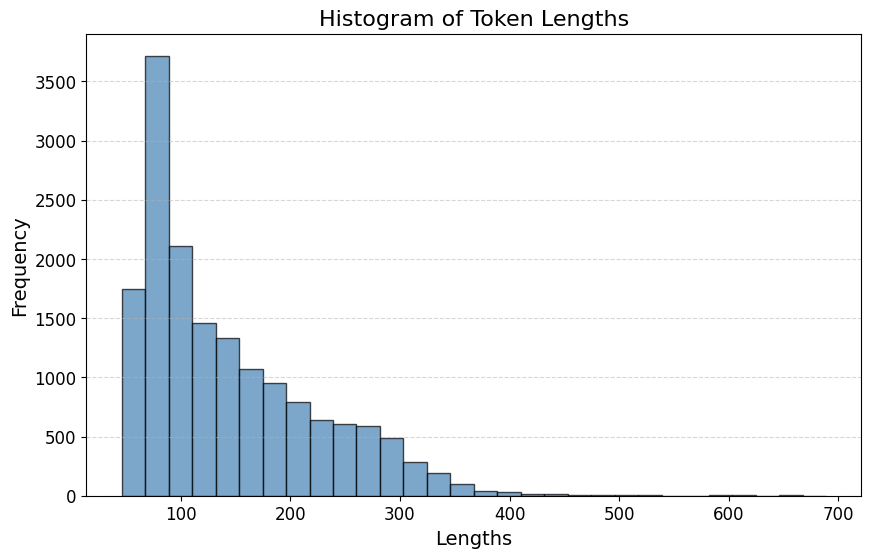

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# '상관 관계'가 데이터를 포함하는 사전이라고 가정합니다.

# 플롯과 히스토그램 설정
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, edgecolor='black', color='steelblue', alpha=0.7)

# 플롯의 모양 사용자 지정
plt.title("Histogram of Token Lengths", fontsize=16)
plt.xlabel("Lengths", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')

# 히스토그램 표시
plt.show()

아래 코드는 모델의 유효성 검사(validation)를 위한 데이터 준비 및 평가자(evaluator) 설정을 수행하는 과정입니다:

1. `all_examples_val = val_positive_pairs + val_negative_pairs`: 
   - 이 코드는 검증용으로 생성된 긍정 쌍(`val_positive_pairs`)과 부정 쌍(`val_negative_pairs`)을 통합하여 `all_examples_val` 리스트를 생성합니다.
   - `all_examples_val`은 모든 검증용 데이터를 포함하는 리스트가 됩니다.

2. 검증용 데이터에서 문장과 점수 추출:
   - `all_examples_val`에서 첫 번째 문장을 `val_sentences1` 리스트에 추출합니다.
   - `all_examples_val`에서 두 번째 문장을 `val_sentences2` 리스트에 추출합니다.
   - `all_examples_val`에서 레이블(점수)를 `val_scores` 리스트에 추출합니다.

3. 평가자 생성:
   - `evaluation.EmbeddingSimilarityEvaluator` 클래스를 사용하여 평가자를 생성합니다.
   - 생성자에 `val_sentences1`, `val_sentences2`, `val_scores`를 전달하여 평가자를 초기화합니다.
   - 평가자는 모델의 성능을 평가하는 데 사용됩니다.

이 코드는 검증용 데이터를 준비하고, 평가자를 설정하는 과정을 나타냅니다. 이렇게 준비된 데이터와 평가자는 모델의 유효성 검사 단계에서 사용되어 모델의 성능을 평가하는 데 활용됩니다.

In [ ]:
# 검증용으로 생성된 긍정, 부정 데이터를 통합
all_examples_val = val_positive_pairs + val_negative_pairs

# 유효성 검사 예제에서 문장 및 점수 추출하기
val_sentences1 = [ex.texts[0] for ex in all_examples_val]
val_sentences2 = [ex.texts[1] for ex in all_examples_val]
val_scores = [ex.label for ex in all_examples_val]

# 평가자 만들기
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_sentences1, val_sentences2, val_scores)

## 3.3 튜닝 전 모델 성능 측정

In [49]:
# 원래 아키텍처는 제한이 128이므로 너무 많은 컨텍스트가 잘립니다.
SentenceTransformer('paraphrase-distilroberta-base-v1').evaluate(evaluator)  

-0.025314296502858342

In [50]:
# model.max_seq_length를 384로 설정한 경우 성능이 약간 개선됨
model.evaluate(evaluator)

0.012507827279691283

## 3.4 모델 학습

아래 코드는 모델 훈련을 위한 데이터 준비 및 훈련 설정을 수행하는 과정입니다:

1. `all_train_examples = train_positive_pairs + train_negative_pairs`:
   - 이 코드는 훈련용으로 생성된 긍정 쌍(`train_positive_pairs`)과 부정 쌍(`train_negative_pairs`)을 통합하여 `all_train_examples` 리스트를 생성합니다.
   - `all_train_examples`은 모든 훈련용 데이터를 포함하는 리스트가 됩니다.

2. 데이터 로더 생성:
   ```python
   train_dataloader = DataLoader(
       all_train_examples,
       batch_size=16,
       shuffle=True
   )
   ```
   - `DataLoader` 클래스를 사용하여 `all_train_examples`을 배치 단위로 로드하는 데이터 로더를 생성합니다.
   - `batch_size=16`은 한 번에 처리할 데이터의 개수를 의미합니다.
   - `shuffle=True`는 데이터를 무작위로 섞어서 로드하도록 설정합니다.

3. 손실 함수 정의:
   ```python
   loss = losses.CosineSimilarityLoss(model=model)
   ```
   - `losses.CosineSimilarityLoss` 클래스를 사용하여 코사인 유사도 손실 함수를 정의합니다.
   - `model=model`은 손실 함수에 사용될 모델을 지정합니다.

4. 모델 훈련 설정:
   ```python
   num_epochs = 5
   warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
   ```
   - `num_epochs = 5`는 모델을 훈련할 에폭(epoch) 수를 설정합니다. 여기서는 5번의 에폭 동안 모델을 훈련합니다.
   - `warmup_steps`는 학습률 워밍업(learning rate warm-up)을 위한 스텝 수를 계산합니다. 여기서는 전체 훈련 데이터의 10%에 해당하는 스텝 수를 사용합니다.

이 코드는 훈련용 데이터를 준비하고, 데이터 로더를 생성하며, 손실 함수를 정의하고, 모델 훈련을 위한 설정을 수행하는 과정을 나타냅니다.

- `all_train_examples`는 훈련에 사용될 모든 데이터를 포함하는 리스트입니다.
- `train_dataloader`는 훈련 데이터를 배치 단위로 로드하는 데이터 로더입니다.
- `loss`는 모델 훈련에 사용될 손실 함수입니다.
- `num_epochs`는 모델을 훈련할 에폭 수를 지정합니다.
- `warmup_steps`는 학습률 워밍업을 위한 스텝 수를 계산합니다.

이렇게 준비된 데이터와 설정은 모델 훈련 과정에서 사용되어 모델이 데이터로부터 학습할 수 있도록 합니다.

In [51]:
# 훈련용으로 생성된 긍정, 부정 데이터를 통합
all_train_examples = train_positive_pairs + train_negative_pairs

# 훈련을 위한 데이터로더 생성하기
train_dataloader = DataLoader(
    all_train_examples,
    batch_size=16,
    shuffle=True
)

# 손실 함수 정의
loss = losses.CosineSimilarityLoss(model=model)

# 모델 훈련 설정
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

아래 코드는 모델을 CPU로 이동하고, 모델 훈련을 수행하는 부분입니다. 코드의 각 부분을 자세히 설명하겠습니다:

1. 모델을 CPU로 이동:
   ```python
   model = model.to('cpu')
   ```
   - `model.to('cpu')`는 모델을 CPU로 이동시키는 코드입니다.
   - 이는 모델의 연산을 CPU에서 수행하도록 설정합니다. GPU가 없는 환경에서 실행할 때 필요합니다.

2. 모델 훈련:
   ```python
   model.fit(
       train_objectives=[(train_dataloader, loss)],
       epochs=num_epochs,
       warmup_steps=warmup_steps,
       evaluator=evaluator,
       output_path="anime_encoder"
   )
   ```
   - `model.fit()` 함수를 사용하여 모델 훈련을 수행합니다.
   - `train_objectives` 매개변수는 훈련 목적을 설정합니다. 여기서는 `train_dataloader`와 `loss` 함수를 튜플로 전달하여 훈련 데이터와 손실 함수를 지정합니다.
   - `epochs` 매개변수는 훈련할 에폭 수를 설정합니다. 앞서 `num_epochs`로 지정한 값이 사용됩니다.
   - `warmup_steps` 매개변수는 학습률 워밍업을 위한 스텝 수를 설정합니다. 앞서 계산한 `warmup_steps` 값이 사용됩니다.
   - `evaluator` 매개변수는 모델 평가를 위한 평가자를 설정합니다. 앞서 생성한 `evaluator`가 사용됩니다.
   - `output_path` 매개변수는 훈련된 모델의 출력 경로를 지정합니다. 여기서는 "anime_encoder"라는 이름으로 모델이 저장됩니다.

이 코드는 모델을 CPU로 이동시키고, `model.fit()` 함수를 사용하여 모델 훈련을 수행합니다.

- 모델은 CPU에서 연산을 수행하도록 설정됩니다.
- 훈련 데이터로더(`train_dataloader`)와 손실 함수(`loss`)를 사용하여 모델을 훈련합니다.
- 지정된 에폭 수(`num_epochs`)만큼 훈련이 반복됩니다.
- 학습률 워밍업을 위해 `warmup_steps`가 사용됩니다.
- 훈련 중에 `evaluator`를 사용하여 모델의 성능을 평가합니다.
- 훈련이 완료되면 모델이 "anime_encoder"라는 경로에 저장됩니다.

이렇게 훈련된 모델은 애니메이션 관련 태스크에 사용될 수 있습니다. 저장된 모델 파일을 로드하여 추론 또는 평가에 활용할 수 있습니다.

In [52]:
# 모델을 CPU로 이동
model = model.to('cpu')

# 트레이닝
model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=evaluator,
    output_path="anime_encoder",
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

## 3.5 모델 성능 측정 및 저장

In [53]:
model.evaluate(evaluator)

0.6754578074496205

In [54]:
model.save("anime_encoder")

# 4. all-mpnet-base-v2 튜닝

## 4.1 모델 초기화

In [55]:
import torch
torch.cuda.empty_cache()

In [56]:
from sentence_transformers import SentenceTransformer, evaluation, losses

# 사전 학습된 SBERT 모델 로드
model = SentenceTransformer('all-mpnet-base-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## 4.2 학습 데이터 생성

In [57]:
# 양수 및 음수 쌍 결합
all_train_examples = train_positive_pairs + train_negative_pairs

# 예제를 위한 데이터로더 생성하기
train_dataloader = DataLoader(
    all_train_examples,
    batch_size=16,
    shuffle=True
)

# 손실 함수 정의
loss = losses.CosineSimilarityLoss(model=model)

## 4.3 튜닝 전 모델 성능 측정

In [58]:
model.evaluate(evaluator)

0.04310984289938541

## 4.4 모델 학습

In [59]:
# 모델 학습
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

In [ ]:
# 모델을 CPU로 이동
model = model.to('cpu')

# 트레이닝 설정
model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=evaluator,
    output_path="anime_encoder_bigger"
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

Iteration:   0%|          | 0/157 [00:00<?, ?it/s]

## 4.5 모델 성능 측정 및 저장

In [ ]:
model.evaluate(evaluator)

In [ ]:
model.save('anime_encoder_bigger')

Q: paraphrase-distilroberta-base-v1 모델과 all-mpnet-base-v2 은 어떤 차이가 있나요?

A: paraphrase-distilroberta-base-v1 모델과 all-mpnet-base-v2 모델은 모두 자연어 처리를 위한 사전 훈련된 언어 모델이지만, 아키텍처와 훈련 방식에 차이가 있습니다.

1. 아키텍처:
- paraphrase-distilroberta-base-v1: 이 모델은 RoBERTa (Robustly Optimized BERT Pretraining Approach) 아키텍처를 기반으로 합니다. RoBERTa는 BERT의 변형으로, 더 큰 배치 크기, 더 긴 훈련 시간, 동적 마스킹 등의 기술을 사용하여 성능을 개선하였습니다. paraphrase-distilroberta-base-v1은 RoBERTa를 knowledge distillation을 통해 압축한 버전입니다.
- all-mpnet-base-v2: 이 모델은 MPNet (Masked and Permuted Pre-training) 아키텍처를 기반으로 합니다. MPNet은 BERT와 XLNet의 장점을 결합한 모델로, 마스킹과 순열 언어 모델링을 모두 사용하여 사전 훈련됩니다.

2. 훈련 방식:
- paraphrase-distilroberta-base-v1: 이 모델은 RoBERTa를 paraphrase detection 태스크에 대해 fine-tuning한 후, knowledge distillation을 통해 압축하였습니다. 이를 통해 모델 크기를 줄이면서도 높은 성능을 유지할 수 있습니다.
- all-mpnet-base-v2: 이 모델은 다양한 태스크에 대해 fine-tuning되지 않았습니다. 대신, 대규모 코퍼스에 대한 사전 훈련에 초점을 맞추어 일반적인 언어 이해 능력을 획득하였습니다.

3. 성능:
- paraphrase-distilroberta-base-v1: Paraphrase detection 태스크에 특화되어 있어, 문장 간 유사성 판단에 높은 성능을 보입니다.
- all-mpnet-base-v2: 다양한 자연어 처리 태스크에서 우수한 성능을 보이며, 특히 의미 검색과 관련된 태스크에서 좋은 결과를 보여줍니다.

4. 모델 크기:
- paraphrase-distilroberta-base-v1: Knowledge distillation을 통해 압축되어, 모델 크기가 상대적으로 작습니다.
- all-mpnet-base-v2: 모델 크기가 paraphrase-distilroberta-base-v1에 비해 큽니다.

두 모델은 각각의 장단점이 있으므로, 태스크의 특성과 리소스 제약 조건에 따라 적절한 모델을 선택해야 합니다. Paraphrase detection과 같은 특정 태스크에는 paraphrase-distilroberta-base-v1이 더 적합할 수 있으며, 보다 일반적인 언어 이해 능력이 필요한 경우에는 all-mpnet-base-v2가 더 나은 선택일 수 있습니다.

# 5. 임베딩 성능 비교

## 5.1 OpenAI 초기화

In [ ]:
from openai import OpenAI
import os

In [ ]:
openai_key=os.environ.get("OPENAI_API_KEY")
client = OpenAI(
    api_key=openai_key
)

In [ ]:
# OpenAI API에서 임베딩 목록을 가져오는 헬퍼 함수
def get_embeddings(texts, engine):
    response = client.embeddings.create(
        input=texts,
        model=engine
    )
    
    return [d.embedding for d in list(response.data)]

def get_embedding(text, engine):
    return get_embeddings([text], engine)[0]

## 5.2 임베딩 모델 선정

In [ ]:
embeddings = {}

In [ ]:
embedders = ('text-embedding-ada-002', 'text-embedding-3-small', 'text-embedding-3-large', 'paraphrase-distilroberta-base-v1', 'all-mpnet-base-v2', 'anime_encoder', 'anime_encoder_bigger')

## 5.3 임베딩 모델 별 임베딩 생성

아래 코드는 문서 임베딩을 생성하는 과정을 보여줍니다. 각 부분을 자세히 설명하겠습니다:

1. `from sentence_transformers import SentenceTransformer`: Sentence-BERT 라이브러리에서 `SentenceTransformer` 모듈을 임포트합니다.

2. `docs = pre_merged_anime['generated_description'].tolist()`: `pre_merged_anime` 데이터프레임의 `'generated_description'` 열의 값들을 리스트로 변환하여 `docs` 변수에 저장합니다.

3. `for embedder in embedders:` 루프를 사용하여 `embedders` 리스트의 각 임베더에 대해 반복합니다.

4. `if embedder in embeddings: continue`: 현재 임베더가 이미 `embeddings` 딕셔너리에 존재하는 경우, 다음 임베더로 건너뜁니다.

5. `if 'text-embedding' in embedder:` 블록은 OpenAI의 Ada 모델을 사용하여 임베딩을 생성하는 경우를 처리합니다.
   - `ada_embeddings = None`: `ada_embeddings` 변수를 초기화합니다.
   - `for s in tqdm(range(0, len(docs), 100)):` 루프를 사용하여 `docs` 리스트를 100개씩 분할하여 처리합니다.
     - `if ada_embeddings is None:` 블록은 `ada_embeddings`가 초기화되지 않은 경우를 처리합니다.
       - `ada_embeddings = np.array(get_embeddings(docs[s:s+100], engine=embedder))`: `get_embeddings` 함수를 사용하여 현재 분할된 문서에 대한 임베딩을 생성하고, NumPy 배열로 변환하여 `ada_embeddings`에 할당합니다.
     - `else:` 블록은 이전에 생성된 임베딩이 있는 경우를 처리합니다.
       - `ada_embeddings = np.vstack([ada_embeddings, np.array(get_embeddings(docs[s:s+100], engine=embedder))])`: 현재 분할된 문서에 대한 임베딩을 생성하고, 이전 임베딩과 수직으로 결합하여 `ada_embeddings`를 업데이트합니다.
   - `embeddings[embedder] = ada_embeddings`: 생성된 임베딩을 `embeddings` 딕셔너리에 저장합니다.

6. `else:` 블록은 Sentence-BERT 모델을 사용하여 임베딩을 생성하는 경우를 처리합니다.
   - `e = SentenceTransformer(embedder, device='cpu')`: 지정된 임베더를 사용하여 `SentenceTransformer` 모델을 로드하고, CPU 디바이스를 사용하도록 설정합니다.
   - `embeddings[embedder] = e.encode(docs, batch_size=128, show_progress_bar=True)`: 로드된 모델을 사용하여 `docs` 리스트의 문서들을 인코딩하고, 생성된 임베딩을 `embeddings` 딕셔너리에 저장합니다. 배치 크기는 128로 설정되며, 진행 상황 막대가 표시됩니다.

이 코드는 `embedders` 리스트에 지정된 임베더들을 사용하여 문서 임베딩을 생성하고, 생성된 임베딩을 `embeddings` 딕셔너리에 저장합니다. OpenAI의 Ada 모델을 사용하는 경우, 문서를 100개씩 분할하여 처리하고 임베딩을 생성합니다. Sentence-BERT 모델을 사용하는 경우, 모델을 로드하고 CPU 디바이스를 사용하여 문서 전체에 대한 임베딩을 한 번에 생성합니다.

In [ ]:
from tqdm.auto import tqdm

'''
사용자 아이디가 주어지면

가 주어지면 사용자가 9 또는 10을 준 각 애니메이션에 대한 사용자 ID를 반환합니다:
    다른 관련 애니메이션 k개 가져오기(임베더가 주어진 시맨틱 검색)
    를 가져옵니다:
        애니메이션이 해당 사용자에 대한 훈련 세트에서 평점을 받았다면 무시합니다.
        해당 애니메이션이 해당 사용자에 대한 테스트 세트에 없으면 무시합니다.
        를 무시합니다:
            해당 사용자에 대한 테스트에서 평점 확인
            케이스 등급:
                9,10 -> 프로모터 (+ 2점)
                7,8 -> 패시브 ( + 1점 )
                1-6 -> 디트랙터 ( - 1 점 )
                세트에 없음 (0점)
                
Given a user id

for each anime that the user gave a 9 or a 10 for:
    get k other relevant animes (semantic search given an embedder)
    for each relevant anime:
        if the anime was rating in the training set for that user, ignore
        elif the anime is not present in the testing set for that user, ignore
        else:
            check rating in testing for that user
            case rating:
                9,10 -> Promoter  ( + 2 points)
                7,8  -> Passive   ( + 1 point )
                1-6  -> Detractor ( - 1 point )
                Not in the set    (   0 points)

'''

from sentence_transformers import SentenceTransformer

docs = pre_merged_anime['generated_description'].tolist()
for embedder in embedders:
    if embedder in embeddings:
        continue
    if 'text-embedding' in embedder:
        ada_embeddings = None
        for s in tqdm(range(0, len(docs), 100)):
            if ada_embeddings is None:
                ada_embeddings = np.array(get_embeddings(docs[s:s+100], engine=embedder))
            else:
                ada_embeddings = np.vstack([ada_embeddings, np.array(get_embeddings(docs[s:s+100], engine=embedder))])
    
        embeddings[embedder] = ada_embeddings
    else:
        # e = SentenceTransformer(embedder)
        e = SentenceTransformer(embedder, device='cpu')
        embeddings[embedder] = e.encode(docs, batch_size=128, show_progress_bar=True)


## 5.4 코사인 유사도 생성

아래 코드는 임베딩 벡터들 간의 코사인 유사도를 계산하여 유사도 행렬을 생성하는 과정입니다. 각 부분을 자세히 설명하겠습니다:

1. `import pandas as pd`: Pandas 라이브러리를 불러옵니다. Pandas는 데이터 조작 및 분석을 위한 파이썬 라이브러리입니다.

2. `import numpy as np`: NumPy 라이브러리를 불러옵니다. NumPy는 대규모 다차원 배열과 행렬 연산에 필요한 다양한 함수를 제공하는 파이썬 라이브러리입니다.

3. `from sklearn.metrics.pairwise import cosine_similarity`: Scikit-learn 라이브러리의 `metrics.pairwise` 모듈에서 `cosine_similarity` 함수를 불러옵니다. 이 함수는 벡터들 간의 코사인 유사도를 계산하는 데 사용됩니다.

4. `cosine_sim_matrices = {embedder: cosine_similarity(embeddings[embedder]) for embedder in embedders}`: 딕셔너리 컴프리헨션을 사용하여 각 임베더(embedder)에 대한 코사인 유사도 행렬을 계산하고, 그 결과를 `cosine_sim_matrices` 딕셔너리에 저장합니다.
   - `embedder`는 `embedders` 리스트의 각 원소를 나타냅니다.
   - `embeddings[embedder]`는 해당 임베더를 사용하여 생성된 임베딩 벡터들을 가져옵니다.
   - `cosine_similarity(embeddings[embedder])`는 `embeddings[embedder]`의 벡터들 간의 코사인 유사도를 계산합니다. 이 함수는 벡터들 간의 유사도를 나타내는 행렬을 반환합니다.
   - 계산된 코사인 유사도 행렬은 `cosine_sim_matrices` 딕셔너리에 `embedder`를 키로 하여 저장됩니다.

이 코드는 `embeddings` 딕셔너리에 저장된 각 임베더의 임베딩 벡터들을 사용하여 코사인 유사도 행렬을 계산합니다. 코사인 유사도는 벡터 간의 각도를 기반으로 유사도를 측정하는 방법으로, 값이 1에 가까울수록 벡터들이 유사하다는 것을 의미합니다.

계산된 코사인 유사도 행렬은 `cosine_sim_matrices` 딕셔너리에 저장되며, 각 임베더에 대한 유사도 행렬을 개별적으로 접근할 수 있습니다. 예를 들어, `cosine_sim_matrices['text-embedding-ada-002']`는 `'text-embedding-ada-002'` 임베더를 사용하여 생성된 임베딩 벡터들 간의 코사인 유사도 행렬을 나타냅니다.

이렇게 계산된 유사도 행렬은 추천 시스템, 문서 클러스터링, 유사 항목 검색 등 다양한 애플리케이션에서 활용될 수 있습니다.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrices = {embedder: cosine_similarity(embeddings[embedder]) for embedder in embedders}

In [ ]:
embeddings["text-embedding-ada-002"].shape

In [ ]:
cosine_sim_matrices["text-embedding-ada-002"].shape

In [ ]:
embeddings["text-embedding-ada-002"][0]

In [ ]:
cosine_sim_matrices["text-embedding-ada-002"][0]

In [ ]:
cosine_sim_matrices["text-embedding-ada-002"][1]

## 5.5 유사한 애니메이션 조회

아래 코드는 주어진 애니메이션과 유사한 애니메이션을 찾는 함수 `get_similar_animes`를 정의하고 있습니다. 함수의 동작을 단계별로 설명하겠습니다:

1. `@functools.lru_cache(maxsize=None)`: 함수의 반환 값을 캐시하는 데코레이터입니다. 동일한 입력에 대해 함수를 반복적으로 호출할 때, 이전에 계산된 결과를 재사용하여 성능을 향상시킵니다. `maxsize=None`은 캐시 크기에 제한이 없음을 의미합니다.

2. 함수의 입력 매개변수:
   - `anime_id`: 유사한 애니메이션을 찾고자 하는 애니메이션의 MAL_ID입니다.
   - `embedder`: 사용할 임베더의 이름을 나타내는 문자열입니다.
   - `k`: 반환할 유사한 애니메이션의 개수를 지정하는 정수이며, 기본값은 10입니다.
   - `verbose`: 디버깅 정보를 출력할지 여부를 결정하는 부울 값이며, 기본값은 False입니다.

3. `pre_merged_anime` 데이터 프레임에서 주어진 `anime_id`에 해당하는 애니메이션의 인덱스를 가져옵니다. 해당 애니메이션이 존재하지 않는 경우 빈 리스트를 반환합니다.

4. `verbose`가 True인 경우, 디버깅 정보로 애니메이션의 인덱스를 출력합니다.

5. `cosine_sim_matrices` 딕셔너리에서 지정된 `embedder`에 해당하는 코사인 유사도 행렬을 가져옵니다.

6. 주어진 `anime_id`에 해당하는 애니메이션과 다른 모든 애니메이션 간의 코사인 유사도 점수를 가져와 `sim_scores` 리스트에 저장합니다.

7. `sim_scores` 리스트를 유사도 점수를 기준으로 내림차순 정렬합니다.

8. 정렬된 `sim_scores` 리스트에서 가장 유사한 애니메이션 `k`개의 인덱스와 점수를 `k_indices_scores` 리스트에 저장합니다. 이때 자기 자신은 제외합니다.

9. `k_indices_scores` 리스트에서 인덱스와 점수를 분리하여 `k_indices`와 `k_scores` 리스트에 저장합니다.

10. `pre_merged_anime` 데이터 프레임에서 `k_indices`에 해당하는 애니메이션의 MAL_ID를 가져와 `k_anime_ids` 리스트에 저장합니다.

11. `k_anime_ids`와 `k_scores`를 zip하여 (MAL_ID, 유사도 점수) 튜플의 리스트 형태로 반환합니다.

이 함수는 주어진 애니메이션과 유사한 애니메이션을 찾아 그 결과를 반환합니다. 유사도는 임베딩 벡터 간의 코사인 유사도를 기준으로 계산되며, 지정된 `embedder`에 따라 다른 임베딩 벡터가 사용됩니다. 반환되는 결과는 (MAL_ID, 유사도 점수) 튜플의 리스트 형태로, 유사도 점수가 높은 순서로 정렬되어 있습니다.

In [ ]:
import functools
from typing import List, Tuple

@functools.lru_cache(maxsize=None)
def get_similar_animes(anime_id: int, embedder: str, k: int = 10, verbose: bool = False) -> List[Tuple[int, float]]:
    # pre_merged_anime 데이터 프레임에서 애니메이션의 인덱스를 가져옵니다.
    try:
        idx = pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id].index[0]
    except:
        return []
    if verbose:
        print(f'idx: {idx}')
    cosine_sim_matrix = cosine_sim_matrices[embedder]

    # 주어진 anime_id에 대한 코사인 유사도 점수를 가져옵니다.
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # 유사도 점수에 따라 애니메이션을 정렬합니다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 애니메이션의 인덱스와 점수를 가져옵니다.
    k_indices_scores = sim_scores[1:k+1]

    # 인덱스와 점수 분리
    k_indices = [i[0] for i in k_indices_scores]
    k_scores = [round(i[1], 3) for i in k_indices_scores]

    # 가장 유사한 애니메이션 k개의 MAL_ID를 가져옵니다.
    k_anime_ids = pre_merged_anime['MAL_ID'].iloc[k_indices].tolist()

    # MAL_ID와 해당 유사도 점수를 반환합니다.
    return list(zip(k_anime_ids, k_scores))

In [ ]:
pre_merged_anime

In [ ]:
cosine_sim_matrices["text-embedding-ada-002"][0]

In [ ]:
enumerate(cosine_sim_matrices["text-embedding-ada-002"][0])

In [ ]:
list(enumerate(cosine_sim_matrices["text-embedding-ada-002"][0]))

In [ ]:
sorted(list(enumerate(cosine_sim_matrices["text-embedding-ada-002"][0])), key=lambda x: x[1], reverse=True)

In [ ]:
pre_merged_anime['Name'].iloc[[i[0] for i in sorted(list(enumerate(cosine_sim_matrices["text-embedding-ada-002"][0])), key=lambda x: x[1], reverse=True)]].tolist()

In [ ]:
rating_complete_train

## 5.6 사용자 평가에 의한 애니메이션 추천

이 함수는 주어진 사용자 ID를 기반으로 사용자가 높은 평점(9점 이상)을 부여한 애니메이션의 리스트를 반환합니다.

함수의 동작을 자세히 설명하겠습니다:

1. `rating_complete_train` 데이터프레임에서 다음 조건을 만족하는 행을 선택합니다:
   - `rating_complete_train['user_id'] == user_id`: 데이터프레임의 'user_id' 열이 주어진 `user_id`와 일치하는 행을 선택합니다.
   - `rating_complete_train['rating'] >= 9`: 데이터프레임의 'rating' 열이 9 이상인 행을 선택합니다.
   
   이 두 조건을 `&` 연산자로 결합하여 두 조건을 모두 만족하는 행만 선택합니다.

2. 선택된 행들 중에서 `['anime_id']` 열만 추출합니다. 이렇게 하면 해당 사용자가 높은 평점을 부여한 애니메이션의 ID 값들만 선택됩니다.

3. `.tolist()` 메서드를 사용하여 선택된 애니메이션 ID 값들을 리스트 형태로 변환합니다.

4. 변환된 리스트를 함수의 반환값으로 반환합니다.

따라서 `get_promoted_animes_from_user` 함수는 주어진 `user_id`에 해당하는 사용자가 9점 이상의 높은 평점을 부여한 애니메이션의 ID 리스트를 반환합니다. 이 함수는 사용자가 선호하는 애니메이션을 추출하는 데 사용될 수 있습니다.

예를 들어, `get_promoted_animes_from_user(1234)`를 호출하면 사용자 ID가 1234인 사용자가 9점 이상으로 평가한 모든 애니메이션의 ID 리스트를 반환합니다.

In [ ]:
def get_promoted_animes_from_user(user_id):
    return rating_complete_train[(rating_complete_train['user_id'] == user_id) & (rating_complete_train['rating'] >= 9)]['anime_id'].tolist()

## 5.7 유사한 애니메이션 추천

위의 코드는 `get_relevant_animes` 함수를 정의하고 있습니다. 이 함수는 주어진 애니메이션과 유사한 애니메이션을 추천하는 역할을 합니다.

함수의 동작을 단계별로 설명하겠습니다:

1. 함수의 입력 매개변수:
   - `reference_promoted_anime_id`: 추천을 위한 기준이 되는 애니메이션의 ID입니다.
   - `embedder`: 사용할 임베더의 이름을 나타내는 문자열입니다.
   - `k`: 추천할 애니메이션의 개수를 지정하는 정수이며, 기본값은 5입니다.
   - `verbose`: 디버깅 정보를 출력할지 여부를 결정하는 부울 값이며, 기본값은 True입니다.

2. `preds` 리스트를 초기화합니다. 이 리스트에는 추천된 애니메이션의 ID와 코사인 유사도 점수가 저장됩니다.

3. `get_similar_animes` 함수를 호출하여 `reference_promoted_anime_id`와 유사한 애니메이션을 `k`개 가져옵니다. 이 함수는 지정된 `embedder`를 사용하여 유사도를 계산합니다.

4. 반환된 유사한 애니메이션을 `similar_animes` 리스트에 저장합니다. 각 항목은 (애니메이션 ID, 코사인 유사도 점수) 튜플 형태입니다.

5. `similar_animes` 리스트를 반복하면서 각 항목에 대해 다음 작업을 수행합니다:
   - 코사인 유사도 점수가 1 이상인 경우(즉, 자기 자신과 동일한 애니메이션인 경우) 해당 항목을 건너뜁니다.
   - `verbose`가 True인 경우, 디버깅 정보로 추천된 애니메이션의 ID와 코사인 유사도 점수를 출력합니다.
   - `user_rating` 변수를 사용하여 사용자가 해당 애니메이션에 부여한 평점을 출력합니다. 그러나 이 부분은 코드에서 `user_rating`이 정의되지 않았기 때문에 오류가 발생할 것입니다.
   - 추천된 애니메이션의 ID와 코사인 유사도 점수를 `preds` 리스트에 추가합니다.

6. 추천된 애니메이션의 ID와 코사인 유사도 점수가 저장된 `preds` 리스트를 반환합니다.

이 함수는 주어진 애니메이션과 유사한 애니메이션을 추천하는 역할을 합니다. 유사도는 `get_similar_animes` 함수를 사용하여 계산되며, 지정된 `embedder`에 따라 다른 임베딩 벡터가 사용됩니다. 반환되는 결과는 (애니메이션 ID, 코사인 유사도 점수) 튜플의 리스트 형태로, 유사도 점수가 높은 순서로 정렬되어 있습니다.

In [ ]:
def get_relevant_animes(reference_promoted_anime_id, embedder, k=5, verbose=True):
    preds = []
    similar_animes = get_similar_animes(reference_promoted_anime_id, embedder, k=k)

    for similar_anime_id, cosine_score in similar_animes:
        if cosine_score >= 1:
            continue  # ignoring exact matches
        if verbose:
            print(f'Recommending (ID {similar_anime_id}) Cos_Sim {cosine_score:.3f}')
        preds.append((similar_anime_id, cosine_score))
    return preds

In [ ]:
pre_merged_anime[pre_merged_anime['MAL_ID'].isin((1723, 4059))]

In [ ]:
anime_id = 4059
k = 10
for e in embedders:
    similar_animes = get_similar_animes(anime_id, e, k=3, verbose=True)
    print(e)
    print(similar_animes)
    print()

In [ ]:
for e in embedders:
    relevant_animes = get_relevant_animes(anime_id, e, k=3, verbose=False)
    print(e)

    # 첫 번째 인자만 추출하여 리스트로 만듦
    mal_ids = [anime[0] for anime in relevant_animes]

    # 추출한 MAL_ID를 이용하여 데이터 필터링
    # filtered_anime = pre_merged_anime[pre_merged_anime['MAL_ID'].isin(mal_ids)]
    filtered_anime = pre_merged_anime[pre_merged_anime['MAL_ID'].isin(mal_ids)][['MAL_ID', 'Name', 'Score']]
    print(filtered_anime)
    print()
    
    # print(relevant_animes)
    # print()

## 5.8 user_id 별 애니메이션 추천

In [ ]:
user_preds = {}

아래 코드는 사용자에 대한 애니메이션 추천을 생성하는 `process_user` 함수를 정의하고 있습니다. 이 함수는 사용자가 높은 평점을 준 애니메이션을 기반으로 유사한 애니메이션을 추천합니다.

함수의 동작을 단계별로 설명하겠습니다:

1. 함수의 입력 매개변수:
   - `user_id`: 추천을 생성할 사용자의 ID입니다.
   - `embedders`: 사용할 임베더 리스트입니다.
   - `K`: 각 임베더에 대해 추천할 애니메이션의 개수를 지정하는 정수입니다.
   - `verbose`: 디버깅 정보를 출력할지 여부를 결정하는 부울 값이며, 기본값은 False입니다.

2. `user_predictions` 딕셔너리를 초기화합니다. 이 딕셔너리는 각 임베더에 대해 사용자의 추천 결과를 저장합니다. 딕셔너리의 키는 임베더이고, 값은 `defaultdict(float)`입니다. `defaultdict(float)`은 애니메이션 ID를 키로 하고, 해당 애니메이션의 추천 점수를 값으로 갖는 딕셔너리입니다.

3. `get_promoted_animes_from_user` 함수를 호출하여 사용자가 높은 평점을 준 애니메이션의 ID 리스트를 가져옵니다. `set`을 사용하여 중복을 제거합니다.

4. 사용자가 높은 평점을 준 각 애니메이션에 대해 다음 작업을 수행합니다:
   - 각 임베더에 대해 `get_relevant_animes` 함수를 호출하여 해당 애니메이션과 유사한 애니메이션을 `K`개 가져옵니다.
   - 유사한 애니메이션의 ID와 코사인 유사도 점수를 `relevant_animes` 리스트에 저장합니다.
   - `relevant_animes` 리스트를 반복하면서 각 항목에 대해 다음 작업을 수행합니다:
     - `verbose`가 True인 경우, 디버깅 정보로 임베더, 사용자 ID, 높은 평점을 받은 애니메이션 ID, 추천된 애니메이션 ID, 코사인 유사도 점수를 출력합니다.
     - `user_predictions` 딕셔너리에서 해당 임베더와 추천된 애니메이션 ID에 대한 기존 점수를 확인합니다. 기존 점수가 없거나 현재 코사인 유사도 점수가 더 높은 경우, 해당 애니메이션 ID에 대한 추천 점수를 업데이트합니다.

5. 함수는 `user_id`와 `user_predictions` 딕셔너리를 튜플 형태로 반환합니다.

이 함수는 주어진 사용자에 대해 높은 평점을 받은 애니메이션을 기반으로 유사한 애니메이션을 추천하는 역할을 합니다. 각 임베더에 대해 추천 결과를 생성하고, 가장 높은 코사인 유사도 점수를 가진 추천 애니메이션을 선택합니다. 최종적으로 사용자 ID와 임베더별 추천 결과를 담은 딕셔너리를 반환합니다.

In [ ]:
from collections import defaultdict
import concurrent.futures
from functools import partial
from tqdm import tqdm

def process_user(user_id, embedders, K, verbose=False):
    user_predictions = {e: defaultdict(float) for e in embedders}
    for promoted_anime_id in set(get_promoted_animes_from_user(user_id)):
        for embedder in embedders:
            relevant_animes = get_relevant_animes(promoted_anime_id, embedder, verbose=False, k=K)
            for anime_id, cosine_score in relevant_animes:
                if verbose:
                    print(embedder, user_id, promoted_anime_id, anime_id, cosine_score)
                if anime_id not in user_predictions[embedder] or cosine_score > user_predictions[embedder][anime_id]:
                    user_predictions[embedder][anime_id] = cosine_score
    return user_id, user_predictions

process_user에서 반환하는 값은 아래와 같은 형태이다.
```JSON
(205282,
 {'text-embedding-ada-002': defaultdict(float,
              {5: 0.913,
               17205: 0.876,
               4037: 0.869,
               21507: 0.913,
               33775: 0.882,
               21195: 0.873,
               1: 0.913,
               3192: 0.864,
               20359: 0.952,
               24627: 0.948,
               ...
               789: 0.859}),
  'text-embedding-3-small': defaultdict(float,
              {5: 0.748,
               4037: 0.631,
               400: 0.628,
               21507: 0.85,
               33775: 0.723,
               269: 0.7,
               1: 0.748,
               15335: 0.862,
               26149: 0.612,
               20359: 0.887,
               ...
               2994: 0.73}),
  'text-embedding-3-large': defaultdict(float,
              {5: 0.732,
               20057: 0.698,
               17205: 0.668,
               21507: 0.755,
               21195: 0.717,
               269: 0.664,
               1: 0.732,
               4037: 0.638,
               20359: 0.872,
               24627: 0.821,
               ...
               789: 0.627}),
  'paraphrase-distilroberta-base-v1': defaultdict(float,
              {4240: 0.622,
               2361: 0.584,
               12149: 0.583,
               21507: 0.712,
               40496: 0.652,
               37202: 0.652,
               1365: 0.571,
               548: 0.559,
               10624: 0.549,
               1554: 0.624,
               ...
               2605: 0.588}),
  'anime_encoder': defaultdict(float,
              {2001: 0.998,
               2598: 0.998,
               2025: 0.998,
               14467: 0.999,
               3091: 0.999,
               8915: 0.999,
               1609: 0.998,
               878: 0.998,
               1133: 0.998,
               25099: 0.999,
               ...
               257: 0.998}),
  'anime_encoder_bigger': defaultdict(float,
              {290: 0.991,
               567: 0.989,
               2598: 0.989,
               4151: 0.994,
               6702: 0.993,
               16518: 0.993,
               15201: 0.995,
               31: 0.994,
               15197: 0.994,
               29854: 0.995,
               ...
               1842: 0.99})})
```

In [ ]:
process_user(205282, embedders, K=3)

## 5.9 테스트 데이터 셋을 이용한 애니메이션 추천 생성

아래 코드는 사용자에 대한 애니메이션 추천을 병렬로 처리하는 부분입니다. 코드의 각 부분을 자세히 설명하겠습니다:

1. 데이터 준비:
   - `user_ids` 변수에 `rating_complete_test` 데이터프레임에서 고유한 사용자 ID를 가져옵니다.
   - `user_ids`는 `user_preds` 딕셔너리의 길이 이후의 사용자 ID부터 선택합니다. 이는 이미 처리된 사용자는 제외하고 새로운 사용자에 대해서만 추천을 생성하기 위함입니다.

2. 작업자 수와 K 값 설정:
   - `num_workers` 변수는 병렬 처리에 사용할 스레드 수를 지정합니다. 사용 가능한 CPU 코어 수와 `user_ids`의 길이 중 작은 값으로 설정됩니다.
   - `K` 변수는 각 사용자에 대해 추천할 애니메이션의 개수를 지정합니다.

3. 병렬 처리를 위한 `ThreadPoolExecutor` 사용:
   - `concurrent.futures.ThreadPoolExecutor`를 사용하여 스레드 풀을 생성합니다. `max_workers` 매개변수는 최대 스레드 수를 지정합니다.
   - `with` 문을 사용하여 스레드 풀의 컨텍스트를 관리합니다. 컨텍스트가 종료되면 스레드 풀이 자동으로 종료됩니다.

4. 부분 함수 생성:
   - `partial` 함수를 사용하여 `process_user` 함수의 일부 인수를 고정하여 새로운 함수를 생성합니다.
   - `process_user_partial` 변수는 `embedders`와 `K` 인수가 고정된 `process_user` 함수를 나타냅니다.

5. 병렬 작업 실행:
   - `executor.map` 메서드를 사용하여 `process_user_partial` 함수를 `user_ids`의 각 사용자 ID에 대해 병렬로 실행합니다.
   - `tqdm` 라이브러리를 사용하여 진행 상황을 표시하고, `total` 매개변수에 `user_ids`의 길이를 전달하여 전체 작업 수를 지정합니다.
   - 각 작업의 결과로 반환되는 `(user_id, user_predictions)` 튜플을 반복하면서, `user_preds` 딕셔너리를 업데이트합니다.
   - `user_preds` 딕셔너리의 키는 `user_id`이고, 값은 해당 사용자에 대한 `user_predictions` 딕셔너리입니다.

이 코드는 `user_ids`의 각 사용자 ID에 대해 `process_user` 함수를 병렬로 실행하여 추천을 생성합니다. 병렬 처리를 통해 여러 사용자에 대한 추천을 동시에 처리할 수 있으므로 전체 실행 시간을 단축할 수 있습니다.

`process_user` 함수는 각 사용자에 대해 높은 평점을 받은 애니메이션을 기반으로 유사한 애니메이션을 추천하고, 그 결과를 `user_predictions` 딕셔너리로 반환합니다. 반환된 `user_predictions` 딕셔너리는 `user_preds` 딕셔너리에 사용자 ID를 키로 하여 저장됩니다.

최종적으로 `user_preds` 딕셔너리에는 각 사용자 ID에 대한 추천 결과가 저장됩니다.

In [ ]:
# 데이터 준비 
user_ids = rating_complete_test['user_id'].unique()[len(user_preds):]

# 작업자 수와 K 값을 설정합니다.
num_workers = min(8, len(user_ids))
K = 3
len(user_ids)

In [ ]:
# 여러 스레드를 사용하여 코드 병렬화하기
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # 임베더와 K에 대한 고정 인수를 사용하여 부분 함수를 생성합니다.
    process_user_partial = partial(process_user, embedders=embedders, K=K)
    
    # 작업을 병렬로 실행하고 user_preds 사전을 업데이트합니다.
    for user_id, user_predictions in tqdm(executor.map(process_user_partial, user_ids), total=len(user_ids)):
        user_preds[user_id] = user_predictions

In [ ]:
len(user_preds)

이 코드는 사용자 추천 결과를 처리하고 저장하는 부분입니다. 코드의 각 부분을 자세히 설명하겠습니다:

1. `convert_float32` 함수:
   - 이 함수는 딕셔너리, 리스트, NumPy의 float32 타입의 값을 재귀적으로 변환합니다.
   - 딕셔너리인 경우, 키-값 쌍을 순회하면서 값에 대해 `convert_float32` 함수를 재귀적으로 호출합니다.
   - 리스트인 경우, 각 항목에 대해 `convert_float32` 함수를 재귀적으로 호출합니다.
   - NumPy의 float32 타입인 경우, `float` 함수를 사용하여 Python의 float 타입으로 변환합니다.
   - 그 외의 경우, 원래의 값을 그대로 반환합니다.

2. `user_preds` 딕셔너리 변환:
   - `user_preds` 딕셔너리의 키를 정수로 변환하여 `user_preds_converted` 딕셔너리를 생성합니다.
   - `convert_float32` 함수를 사용하여 `user_preds_converted` 딕셔너리의 값을 재귀적으로 변환합니다.

3. 변환된 딕셔너리를 JSON 파일로 저장:
   - `with` 문을 사용하여 `user_preds.json` 파일을 쓰기 모드로 열고, `json.dump` 함수를 사용하여 `user_preds_converted` 딕셔너리를 JSON 형식으로 저장합니다.

In [ ]:
import json

# int64 키를 int 또는 str으로 변환
import json

def convert_float32(obj):
    if isinstance(obj, dict):
        return {key: convert_float32(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_float32(item) for item in obj]
    elif isinstance(obj, np.float32):
        return float(obj)
    else:
        return obj

user_preds_converted = {int(key): value for key, value in user_preds.items()}
user_preds_converted = convert_float32(user_preds_converted)

# 생성하는 데 계산 비용이 많이 들기 때문에 저장합니다.
with open('user_preds.json', 'w') as f:
    json.dump(user_preds_converted, f)

In [ ]:
import json
with open('user_preds.json', 'rU') as f:
    user_preds = json.load(f)

1. 총 예측된 애니메이션 계산:
   - `total_animes_predicted` 딕셔너리를 초기화합니다. 각 임베더에 대해 빈 집합을 값으로 갖습니다.
   - `user_preds` 딕셔너리를 순회하면서 각 사용자의 추천 결과를 확인합니다.
  
2. 각 임베더에 대해 추천된 애니메이션의 키를 `total_animes_predicted` 딕셔너리의 해당 임베더 집합에 추가합니다.

    코드에서 `total_animes_predicted[embedder].update((rec.keys()))`는 다음과 같이 동작합니다:
    
    1. `total_animes_predicted`는 각 임베더별로 추천된 애니메이션의 ID를 저장하는 딕셔너리입니다.
       - 키: 임베더 이름 (예: 'text-embedding-ada-002', 'text-embedding-3-small' 등)
       - 값: 해당 임베더가 추천한 애니메이션의 ID를 저장하는 세트(set)
    
    2. `embedder`는 현재 처리 중인 임베더의 이름입니다.
    
    3. `rec`는 현재 임베더가 추천한 애니메이션의 ID와 추천 점수를 담고 있는 defaultdict입니다.
    
    4. `rec.keys()`는 `rec` defaultdict의 키들을 반환합니다. 이 키들은 추천된 애니메이션의 ID입니다.
    
    5. `(rec.keys())`는 `rec.keys()`를 튜플로 변환합니다. 이는 `update()` 메서드에 전달하기 위한 것입니다.
    
    6. `total_animes_predicted[embedder].update((rec.keys()))`는 `total_animes_predicted` 딕셔너리에서 `embedder`에 해당하는 세트(set)를 가져와서 `rec.keys()`로부터 얻은 애니메이션 ID들을 추가합니다.
       - `update()` 메서드는 세트에 여러 개의 요소를 한 번에 추가할 때 사용됩니다.
       - `(rec.keys())`로부터 얻은 애니메이션 ID들이 `total_animes_predicted[embedder]` 세트에 추가됩니다.

    따라서 `total_animes_predicted[embedder].update((rec.keys()))`는 현재 임베더가 추천한 애니메이션의 ID들을 `total_animes_predicted` 딕셔너리의 해당 임베더 세트에 추가하는 역할을 합니다.
    이 코드를 통해 각 임베더별로 추천된 애니메이션의 ID들을 누적하여 저장할 수 있습니다. 최종적으로 `total_animes_predicted` 딕셔너리에는 각 임베더가 추천한 모든 애니메이션의 ID가 세트 형태로 저장됩니다.
    예를 들어, 위의 데이터에서 'text-embedding-ada-002' 임베더가 추천한 애니메이션의 ID들은 `total_animes_predicted['text-embedding-ada-002']` 세트에 추가될 것입니다.

3. 추천된 애니메이션 수 확인:
   - `len(total_animes_predicted)`를 사용하여 `total_animes_predicted` 딕셔너리의 길이를 확인합니다.
   - `rating_complete_test['anime_id'].nunique()`를 사용하여 테스트 데이터셋에서 고유한 애니메이션 수를 확인합니다.
   - `{k: len(v) for k, v in total_animes_predicted.items()}`를 사용하여 각 임베더별로 예측된 고유한 애니메이션 수를 확인합니다.

In [ ]:
total_animes_predicted = {e: set() for e in embedders}
for user_id, recs in user_preds.items():
    for embedder, rec in recs.items():
        total_animes_predicted[embedder].update((rec.keys()))
len(total_animes_predicted)

In [ ]:
rating_complete_test['anime_id'].nunique()

In [ ]:
{k: len(v) for k, v in total_animes_predicted.items()}

In [ ]:
rating_complete_test

## 5.10 애니메이션 추천 시스템 성능 평가

1. 사용자-애니메이션 테스트 평점 딕셔너리 생성:
   - `try-except` 문을 사용하여 `user_anime_test_ratings` 딕셔너리가 존재하는지 확인합니다.
   - 존재하지 않는 경우, `defaultdict(dict)`를 사용하여 `user_anime_test_ratings` 딕셔너리를 초기화합니다.
   - `rating_complete_test` 데이터프레임을 순회하면서 각 행의 사용자 ID, 애니메이션 ID, 평점을 가져옵니다.
   - `user_anime_test_ratings` 딕셔너리에 사용자 ID를 키로, 애니메이션 ID를 내부 딕셔너리의 키로, 평점을 값으로 저장합니다.

In [ ]:
from collections import defaultdict
try:
    user_anime_test_ratings
except:
    user_anime_test_ratings = defaultdict(dict)
    for index, user_id, anime_id, rating in tqdm(rating_complete_test.to_records()):
        user_anime_test_ratings[user_id][anime_id] = rating


이 코드는 추천 시스템의 성능을 평가하기 위해 다양한 k 값(k-factor)에 대한 순 프로모터 점수(NPS)를 계산하는 부분입니다. 코드의 각 부분을 자세히 설명하겠습니다:

1. `tqdm` 라이브러리를 가져와서 진행률 표시줄을 시각화합니다.

2. `score_map` 딕셔너리를 정의하여 사용자 평가 점수를 매핑합니다.
   - 10과 9는 긍정(1), 8과 7은 중립(0), 나머지는 모두 부정(-1)으로 간주합니다.

3. `k_values` 리스트와 `embedder_counts` 딕셔너리를 초기화합니다.
   - `k_values` 리스트는 각 k 값에 대한 평가 결과를 저장합니다.
   - `embedder_counts` 딕셔너리는 각 임베더의 추천에 대한 점수를 저장합니다.

4. 1부터 10까지의 정수 범위를 `_r` 변수에 저장합니다.

5. `_r` 범위를 반복하여 다양한 k 값(k-factor)에 대해 평가를 수행합니다.
   - `tqdm`을 사용하여 진행률 표시줄을 출력합니다.

6. 각 사용자와 해당 추천(`user_preds`)을 반복합니다.

7. 각 임베더와 임베더의 해당 추천을 반복합니다.

8. 각 임베더에서 각 사용자에 대한 상위 k개의 추천을 선택합니다.
   - `sorted` 함수와 `lambda` 함수를 사용하여 추천 점수를 기준으로 내림차순으로 정렬합니다.
   - 상위 k개의 추천을 `final_recs` 변수에 저장합니다.

9. 상위 k 추천을 반복하면서 각 추천에 대해 다음 작업을 수행합니다.
   - 추천 애니메이션에 대한 사용자 평점을 `user_anime_test_ratings` 딕셔너리에서 가져옵니다.
   - 사용자가 추천 애니메이션에 대한 평점을 가지고 있는지 확인합니다.
   - 사용자 평점이 존재하는 경우:
     - `score_map` 딕셔너리를 사용하여 사용자 평점을 점수로 변환합니다.
     - 추천의 순위에 따라 점수를 조정하여 `embedder_counts` 딕셔너리에 추가합니다.

10. 각 임베더의 평균 순 프로모터 점수(NPS)를 계산합니다.
    - `embedder_counts` 딕셔너리의 각 임베더에 대해 점수의 합을 점수의 개수로 나누어 평균 NPS를 계산합니다.
    - 평균 NPS와 함께 k 값과 테스트 세트에서 발견된 예측 수를 포함하는 딕셔너리를 생성합니다.
    - 생성된 딕셔너리를 `k_values` 리스트에 추가합니다.

이 코드는 다양한 k 값에 대해 추천 시스템의 성능을 평가하는 과정을 나타냅니다. 각 k 값에 대해 사용자의 실제 평점과 추천 점수를 비교하여 순 프로모터 점수(NPS)를 계산하고, 평균 NPS와 함께 평가 결과를 `k_values` 리스트에 저장합니다. 이를 통해 최적의 k 값을 선택하고 추천 시스템의 성능을 평가할 수 있습니다.



----------


NPS는 순 프로모터 점수(Net Promoter Score)의 약자입니다. 이는 고객 충성도와 만족도를 측정하는 지표로 널리 사용됩니다. NPS는 고객이 제품, 서비스 또는 브랜드를 다른 사람에게 추천할 가능성을 나타내는 점수입니다.

NPS는 일반적으로 다음과 같은 질문을 통해 수집됩니다:
"0부터 10까지의 척도에서, 귀하는 이 제품/서비스/브랜드를 친구나 동료에게 추천할 가능성이 어느 정도입니까?"

응답자는 0부터 10까지의 점수로 평가합니다. 이 점수에 따라 응답자는 다음과 같이 분류됩니다:
- 9-10: 프로모터(Promoters) - 충성도가 높고 적극적으로 추천할 가능성이 높은 고객
- 7-8: 패시브(Passives) - 만족하지만 충성도가 높지 않은 고객
- 0-6: 디트랙터(Detractors) - 불만족하고 부정적인 구전을 할 가능성이 높은 고객

NPS는 프로모터의 비율에서 디트랙터의 비율을 뺀 값으로 계산됩니다:
NPS = % 프로모터 - % 디트랙터

NPS는 -100부터 100까지의 범위를 가질 수 있습니다. 양수 값은 프로모터가 디트랙터보다 많다는 것을 의미하고, 음수 값은 그 반대를 의미합니다.

위의 코드에서 NPS를 사용한 이유는 추천 시스템의 성능을 평가하기 위해서입니다. 코드에서는 사용자의 실제 평점을 기반으로 추천 시스템이 제공한 추천의 품질을 측정하고 있습니다.

코드에서는 `score_map` 딕셔너리를 사용하여 사용자 평점을 NPS 척도로 매핑합니다:
- 10과 9는 프로모터(1)로 간주
- 8과 7은 패시브(0)로 간주
- 6 이하는 디트랙터(-1)로 간주

추천 시스템이 제공한 각 추천에 대해, 사용자의 실제 평점을 기반으로 NPS 점수를 계산합니다. 이 점수는 추천의 순위에 따라 가중치가 부여됩니다. 상위 순위의 추천이 더 높은 가중치를 받습니다.

각 임베더(추천 알고리즘)에 대해 평균 NPS를 계산하여 추천 시스템의 전반적인 성능을 평가합니다. 평균 NPS가 높을수록 추천 시스템이 사용자의 선호도를 잘 예측하고 만족도 높은 추천을 제공한다는 것을 의미합니다.

NPS를 사용함으로써 추천 시스템의 성능을 정량적으로 평가하고, 다른 알고리즘이나 하이퍼파라미터 설정과 비교할 수 있습니다. 이를 통해 최적의 추천 시스템을 선택하고 사용자 경험을 개선할 수 있습니다.


----------

코드 `embedder_counts[embedder].append((score_map[user_rating] * (k_factor - index) / k_factor))`는 추천 시스템의 성능을 평가하기 위해 사용되는 점수를 계산하고 저장하는 부분입니다. 이 코드의 각 부분을 자세히 설명하겠습니다:

1. `embedder_counts`는 각 임베더(추천 알고리즘)의 성능을 저장하는 딕셔너리입니다.
   - 키: 임베더 이름 (예: 'text-embedding-ada-002', 'text-embedding-3-small' 등)
   - 값: 해당 임베더의 추천에 대한 점수를 저장하는 리스트

2. `embedder`는 현재 처리 중인 임베더의 이름입니다.

3. `score_map`은 사용자 평점을 점수로 매핑하는 딕셔너리입니다.
   - 키: 사용자 평점 (0부터 10까지의 정수)
   - 값: NPS(Net Promoter Score) 척도에 따른 점수 (1: 프로모터, 0: 패시브, -1: 디트랙터)

4. `user_rating`은 사용자가 추천된 애니메이션에 대해 매긴 실제 평점입니다.

5. `score_map[user_rating]`은 사용자 평점을 NPS 점수로 변환합니다.
   - 예를 들어, 사용자 평점이 10이면 NPS 점수는 1(프로모터)이 됩니다.

6. `k_factor`는 현재 평가 중인 k 값(상위 k개 추천)입니다.

7. `index`는 현재 추천의 순위를 나타내는 인덱스입니다.

8. `(k_factor - index) / k_factor`는 추천의 순위에 따른 가중치를 계산하는 식입니다.
   - 상위 순위의 추천일수록 가중치가 높아집니다.
   - 가중치는 1에서 0까지의 값을 가지며, 상위 순위일수록 1에 가까워집니다.

9. `score_map[user_rating] * (k_factor - index) / k_factor`는 사용자 평점을 NPS 점수로 변환한 후, 추천 순위에 따른 가중치를 곱하여 최종 점수를 계산합니다.
   - 사용자 평점이 높고 추천 순위가 상위일수록 최종 점수가 높아집니다.

10. `embedder_counts[embedder].append(...)`는 계산된 최종 점수를 `embedder_counts` 딕셔너리의 해당 임베더 리스트에 추가합니다.

이 코드는 추천 시스템의 성능을 평가할 때, 사용자의 실제 평점과 추천 순위를 모두 고려하여 점수를 계산합니다. 사용자 평점이 높을수록, 그리고 추천 순위가 상위일수록 해당 추천에 대한 점수가 높아집니다. 이렇게 계산된 점수는 `embedder_counts` 딕셔너리에 누적되어 저장됩니다.

최종적으로 `embedder_counts` 딕셔너리를 사용하여 각 임베더의 평균 NPS를 계산하고, 이를 통해 추천 시스템의 전반적인 성능을 평가할 수 있습니다. 이 코드는 추천 시스템의 성능을 정량적으로 측정하고 비교하는 데 사용됩니다.

---------

코드 `k_values.append({e: dict(k=k_factor, avg_nps=sum(l) / len(l), predictions_found_in_test_set=len(l)) for e, l in embedder_counts.items()})`는 각 임베더(추천 알고리즘)의 성능 평가 결과를 `k_values` 리스트에 추가하는 부분입니다. 이 코드의 각 부분을 자세히 설명하겠습니다:

1. `k_values`는 각 k 값(상위 k개 추천)에 대한 평가 결과를 저장하는 리스트입니다.

2. `embedder_counts.items()`는 `embedder_counts` 딕셔너리의 키-값 쌍을 반환합니다.
   - 키(`e`): 임베더 이름 (예: 'text-embedding-ada-002', 'text-embedding-3-small' 등)
   - 값(`l`): 해당 임베더의 추천에 대한 점수를 저장하는 리스트

3. `{e: dict(k=k_factor, avg_nps=sum(l) / len(l), predictions_found_in_test_set=len(l)) for e, l in embedder_counts.items()}`는 딕셔너리 컴프리헨션(dictionary comprehension)을 사용하여 각 임베더의 성능 평가 결과를 계산하고 딕셔너리로 생성합니다.
   - `e`는 임베더 이름을 나타냅니다.
   - `dict(k=k_factor, avg_nps=sum(l) / len(l), predictions_found_in_test_set=len(l))`는 각 임베더의 성능 평가 결과를 담은 딕셔너리를 생성합니다.
     - `k`: 현재 평가 중인 k 값(상위 k개 추천)
     - `avg_nps`: 해당 임베더의 평균 NPS(Net Promoter Score) 점수
       - `sum(l)`은 해당 임베더의 점수 리스트(`l`)의 합계를 계산합니다.
       - `len(l)`은 해당 임베더의 점수 리스트(`l`)의 길이를 계산합니다.
       - `sum(l) / len(l)`은 점수의 평균을 계산합니다.
     - `predictions_found_in_test_set`: 해당 임베더가 테스트 세트에서 발견한 추천 수
       - `len(l)`은 해당 임베더의 점수 리스트(`l`)의 길이를 계산하며, 이는 테스트 세트에서 발견한 추천 수와 동일합니다.

4. `k_values.append(...)`는 생성된 딕셔너리를 `k_values` 리스트에 추가합니다.

이 코드는 각 k 값(상위 k개 추천)에 대해 임베더별 성능 평가 결과를 계산하고 저장합니다. 계산된 결과는 딕셔너리 형태로 `k_values` 리스트에 추가됩니다.

딕셔너리의 구조는 다음과 같습니다:
- 키: 임베더 이름
- 값: 해당 임베더의 성능 평가 결과를 담은 딕셔너리
  - `k`: 현재 평가 중인 k 값
  - `avg_nps`: 해당 임베더의 평균 NPS 점수
  - `predictions_found_in_test_set`: 해당 임베더가 테스트 세트에서 발견한 추천 수

최종적으로 `k_values` 리스트에는 각 k 값에 대한 임베더별 성능 평가 결과가 저장됩니다. 이를 통해 다양한 k 값에 대한 추천 시스템의 성능을 비교하고 분석할 수 있습니다.


-----
embedder_counts

```JSON
{
    'text-embedding-ada-002': [0.8, 0.9, 0.7, 0.6, 0.9, 0.8, 0.7, 0.8, 0.9, 0.7, ...],
    'text-embedding-3-small': [0.7, 0.8, 0.6, 0.5, 0.8, 0.7, 0.6, 0.7, 0.8, 0.6, ...],
    'text-embedding-3-large': [0.75, 0.85, 0.65, 0.55, 0.85, 0.75, 0.65, 0.75, 0.85, 0.65, ...],
    'paraphrase-distilroberta-base-v1': [0.6, 0.7, 0.5, 0.4, 0.7, 0.6, 0.5, 0.6, 0.7, 0.5, ...],
    'anime_encoder': [0.5, 0.6, 0.4, 0.3, 0.6, 0.5, 0.4, 0.5, 0.6, 0.4, ...],
    'anime_encoder_bigger': [0.55, 0.65, 0.45, 0.35, 0.65, 0.55, 0.45, 0.55, 0.65, 0.45, ...]
}
```

k_values

```JSON
[
    {
        'text-embedding-ada-002': {'k': 1, 'avg_nps': 0.85, 'predictions_found_in_test_set': 1000},
        'text-embedding-3-small': {'k': 1, 'avg_nps': 0.80, 'predictions_found_in_test_set': 950},
        'text-embedding-3-large': {'k': 1, 'avg_nps': 0.83, 'predictions_found_in_test_set': 980},
        'paraphrase-distilroberta-base-v1': {'k': 1, 'avg_nps': 0.78, 'predictions_found_in_test_set': 900},
        'anime_encoder': {'k': 1, 'avg_nps': 0.75, 'predictions_found_in_test_set': 850},
        'anime_encoder_bigger': {'k': 1, 'avg_nps': 0.76, 'predictions_found_in_test_set': 870}
    },
    {
        'text-embedding-ada-002': {'k': 2, 'avg_nps': 0.87, 'predictions_found_in_test_set': 2000},
        'text-embedding-3-small': {'k': 2, 'avg_nps': 0.82, 'predictions_found_in_test_set': 1950},
        'text-embedding-3-large': {'k': 2, 'avg_nps': 0.85, 'predictions_found_in_test_set': 1980},
        'paraphrase-distilroberta-base-v1': {'k': 2, 'avg_nps': 0.80, 'predictions_found_in_test_set': 1900},
        'anime_encoder': {'k': 2, 'avg_nps': 0.77, 'predictions_found_in_test_set': 1850},
        'anime_encoder_bigger': {'k': 2, 'avg_nps': 0.78, 'predictions_found_in_test_set': 1870}
    },
    ...
]
```

In [ ]:
# 진행률 표시줄 시각화를 위해 tqdm 가져오기
from tqdm.auto import tqdm

# 사용자 평가 점수를 매기는 맵을 만듭니다.
# 10과 9는 긍정(1), 8과 7은 중립(0), 나머지는 모두 부정(-1)으로 간주합니다.
score_map = {10: 1, 9: 1, 8: 0, 7: 0, 6: -1, 5: -1, 4:-1, 3:-1, 2:-1, 1:-1, 0:-1}

# 각 임베더의 개수에 대한 k_values 목록과 사전을 초기화합니다.
k_values = []
embedder_counts = defaultdict(list)

# 1에서 10까지의 정수 범위 만들기
_r = list(range(1, 11))

# 범위를 반복하여 추천에 대한 다양한 k 값(k-factor)을 얻습니다.
for k_factor in tqdm(_r):
    # 각 사용자와 해당 추천을 반복합니다.
    for user_id, user_recs in user_preds.items():
        # 각 임베더와 임베더의 해당 추천을 반복합니다.
        for embedder, recs_from_embedder in user_recs.items():
            # 각 임베더에서 각 사용자에 대한 상위 k개의 추천 선택
            final_recs = sorted(recs_from_embedder.items(), key=lambda x: x[1], reverse=True)[:k_factor]

            # 상위 k 추천 반복
            for index, (recommended_anime_id, recommendation_score) in enumerate(final_recs):  
                # 추천 애니메이션에 대한 사용자 평점 가져오기
                user_rating = user_anime_test_ratings.get(int(user_id), {}).get(int(recommended_anime_id))

                # 사용자가 추천 애니메이션에 대한 평점을 가지고 있는지 확인합니다.
                if user_rating:
                    # 각 추천의 점수는 순위에 따라 조정되어 embedder_counts 딕셔너리에 추가됩니다.
                    embedder_counts[embedder].append((score_map[user_rating] * (k_factor - index) / k_factor))

    # 각 임베더의 평균 순 프로모터 점수(NPS)를 계산하고 이를 k_values 목록에 추가합니다.
    k_values.append({e: dict(k=k_factor, avg_nps=sum(l) / len(l), predictions_found_in_test_set=len(l)) for e, l in embedder_counts.items()})

embedder_counts 데이터 조회

In [ ]:
first_embedder = list(embedder_counts.keys())[0]
print(f"첫 번째 임베더: {first_embedder}")
print(f"첫 번째 임베더의 점수 개수: {len(embedder_counts[first_embedder])}")
print(f"첫 번째 임베더의 점수 미리보기: {embedder_counts[first_embedder][:5]}")

In [ ]:
for embedder, scores in embedder_counts.items():
    print(f"임베더: {embedder}, 점수 개수: {len(scores)}")

In [ ]:
embedder_counts_summary = {embedder: len(scores) for embedder, scores in embedder_counts.items()}
print("임베더별 점수 개수 요약:")
print(embedder_counts_summary)

In [ ]:
import random

random_embedder = random.choice(list(embedder_counts.keys()))
print(f"랜덤하게 선택한 임베더: {random_embedder}")
print(f"해당 임베더의 점수 개수: {len(embedder_counts[random_embedder])}")
print(f"해당 임베더의 점수 미리보기: {embedder_counts[random_embedder][:5]}")

In [ ]:
len(k_values)

In [ ]:
k_values

이 코드는 추천 시스템의 성능을 평가한 결과를 시각화하는 부분입니다. Matplotlib 라이브러리를 사용하여 각 임베더(추천 알고리즘)의 성능을 라인 플롯으로 표현합니다. 코드의 각 부분을 자세히 설명하겠습니다:

1. 데이터 추출:
   - `models` 리스트는 `k_values` 딕셔너리의 첫 번째 항목에서 임베더 이름을 추출합니다.
   - `ks` 리스트는 각 `k_values` 항목에서 첫 번째 임베더의 "k" 값을 추출합니다. 이는 x축에 사용될 값입니다.
   - `model_avg_nps` 딕셔너리는 각 임베더에 대해 `k_values`의 모든 항목에서 "avg_nps" 값을 추출하여 저장합니다.

2. 그래프 스타일 설정:
   - `plt.style.use('ggplot')`을 사용하여 그래프의 스타일을 'ggplot' 스타일로 설정합니다.
   - `fig, ax = plt.subplots(figsize=(10, 5))`를 사용하여 그래프의 크기를 설정합니다.

3. 색상, 선 스타일, 마커 스타일 정의:
   - `colors` 리스트는 각 임베더에 대한 색상을 정의합니다.
   - `line_styles` 리스트는 각 임베더에 대한 선 스타일을 정의합니다.
   - `marker_styles` 리스트는 각 임베더에 대한 마커 스타일을 정의합니다.

4. 각 임베더에 대한 라인 플롯 그리기:
   - `enumerate(model_avg_nps.items())`를 사용하여 각 임베더와 해당 "avg_nps" 값을 반복합니다.
   - `ax.plot()`을 사용하여 각 임베더의 성능을 라인 플롯으로 그립니다.
     - x축은 `ks` 값을 사용합니다.
     - y축은 해당 임베더의 "avg_nps" 값을 사용합니다.
     - `label` 매개변수는 각 라인의 레이블을 설정합니다.
     - `linewidth`, `marker`, `linestyle`, `color` 매개변수는 라인의 스타일을 설정합니다.

5. 라벨, 제목, 범례 추가:
   - `ax.set_xlabel()`을 사용하여 x축 레이블을 설정합니다.
   - `ax.set_ylabel()`을 사용하여 y축 레이블을 설정합니다.
   - `ax.set_title()`을 사용하여 그래프의 제목을 설정합니다.
   - `ax.legend()`을 사용하여 범례를 추가합니다.

6. 그래프 표시:
   - `plt.show()`를 사용하여 그래프를 화면에 표시합니다.

이 코드는 추천 시스템의 성능 평가 결과를 시각적으로 표현합니다. 각 임베더의 성능은 라인 플롯으로 표현되며, x축은 추천된 아이템의 개수(k)를 나타내고, y축은 평균 추천 점수(Average Rec. Promoted Score)를 나타냅니다. 서로 다른 색상, 선 스타일, 마커 스타일을 사용하여 각 임베더를 구분하여 표시합니다. 이를 통해 다양한 임베더의 성능을 비교하고 분석할 수 있습니다.

----------

코드 `model_avg_nps = {model: [entry[model]["avg_nps"] for entry in k_values] for model in models}`는 딕셔너리 컴프리헨션(dictionary comprehension)을 사용하여 각 임베더(추천 알고리즘)의 평균 NPS(Net Promoter Score) 값을 추출하고 저장하는 부분입니다. 이 코드를 자세히 설명하겠습니다.

1. `models` 리스트:
   - `models` 리스트는 임베더의 이름을 저장하고 있습니다.
   - 이 리스트는 `k_values` 딕셔너리의 첫 번째 항목에서 임베더 이름을 추출하여 생성되었습니다.

2. `for model in models`:
   - 바깥쪽 루프는 `models` 리스트의 각 임베더를 반복합니다.
   - 이 루프는 각 임베더에 대해 평균 NPS 값을 계산하고 저장할 것입니다.

3. `[entry[model]["avg_nps"] for entry in k_values]`:
   - 내부 리스트 컴프리헨션(list comprehension)은 `k_values` 리스트의 각 항목(`entry`)에 대해 반복합니다.
   - 각 `entry`는 딕셔너리 형태로, 임베더 이름을 키로 하고 해당 임베더의 성능 평가 결과를 값으로 가지고 있습니다.
   - `entry[model]`은 현재 반복 중인 임베더(`model`)에 해당하는 성능 평가 결과를 가져옵니다.
   - `entry[model]["avg_nps"]`은 해당 임베더의 "avg_nps" 값을 추출합니다.
   - 내부 리스트 컴프리헨션은 `k_values` 리스트의 모든 항목에 대해 현재 임베더의 "avg_nps" 값을 추출하여 리스트로 만듭니다.

4. `{model: ... for model in models}`:
   - 바깥쪽 딕셔너리 컴프리헨션은 `models` 리스트의 각 임베더에 대해 반복합니다.
   - 각 임베더의 이름(`model`)을 키로 사용하고, 내부 리스트 컴프리헨션에서 계산된 해당 임베더의 "avg_nps" 값들의 리스트를 값으로 사용하여 딕셔너리를 생성합니다.

5. `model_avg_nps` 딕셔너리:
   - 최종적으로 `model_avg_nps` 딕셔너리가 생성됩니다.
   - 이 딕셔너리의 키는 임베더 이름이고, 값은 해당 임베더의 "avg_nps" 값들의 리스트입니다.
   - 예를 들어, `model_avg_nps["text-embedding-ada-002"]`은 "text-embedding-ada-002" 임베더의 "avg_nps" 값들의 리스트를 가져옵니다.

이 코드는 `k_values` 리스트에서 각 임베더의 "avg_nps" 값을 추출하여 `model_avg_nps` 딕셔너리에 저장합니다. 결과적으로 `model_avg_nps` 딕셔너리는 각 임베더의 이름을 키로 하고, 해당 임베더의 평균 NPS 값들의 리스트를 값으로 가지게 됩니다. 이 딕셔너리는 이후에 그래프를 그리는 데 사용됩니다.


----------

embedder_counts

```JSON
{
    'text-embedding-ada-002': [0.8, 0.9, 0.7, 0.6, 0.9, 0.8, 0.7, 0.8, 0.9, 0.7, ...],
    'text-embedding-3-small': [0.7, 0.8, 0.6, 0.5, 0.8, 0.7, 0.6, 0.7, 0.8, 0.6, ...],
    'text-embedding-3-large': [0.75, 0.85, 0.65, 0.55, 0.85, 0.75, 0.65, 0.75, 0.85, 0.65, ...],
    'paraphrase-distilroberta-base-v1': [0.6, 0.7, 0.5, 0.4, 0.7, 0.6, 0.5, 0.6, 0.7, 0.5, ...],
    'anime_encoder': [0.5, 0.6, 0.4, 0.3, 0.6, 0.5, 0.4, 0.5, 0.6, 0.4, ...],
    'anime_encoder_bigger': [0.55, 0.65, 0.45, 0.35, 0.65, 0.55, 0.45, 0.55, 0.65, 0.45, ...]
}
```

k_values

```JSON
[
    {
        'text-embedding-ada-002': {'k': 1, 'avg_nps': 0.85, 'predictions_found_in_test_set': 1000},
        'text-embedding-3-small': {'k': 1, 'avg_nps': 0.80, 'predictions_found_in_test_set': 950},
        'text-embedding-3-large': {'k': 1, 'avg_nps': 0.83, 'predictions_found_in_test_set': 980},
        'paraphrase-distilroberta-base-v1': {'k': 1, 'avg_nps': 0.78, 'predictions_found_in_test_set': 900},
        'anime_encoder': {'k': 1, 'avg_nps': 0.75, 'predictions_found_in_test_set': 850},
        'anime_encoder_bigger': {'k': 1, 'avg_nps': 0.76, 'predictions_found_in_test_set': 870}
    },
    {
        'text-embedding-ada-002': {'k': 2, 'avg_nps': 0.87, 'predictions_found_in_test_set': 2000},
        'text-embedding-3-small': {'k': 2, 'avg_nps': 0.82, 'predictions_found_in_test_set': 1950},
        'text-embedding-3-large': {'k': 2, 'avg_nps': 0.85, 'predictions_found_in_test_set': 1980},
        'paraphrase-distilroberta-base-v1': {'k': 2, 'avg_nps': 0.80, 'predictions_found_in_test_set': 1900},
        'anime_encoder': {'k': 2, 'avg_nps': 0.77, 'predictions_found_in_test_set': 1850},
        'anime_encoder_bigger': {'k': 2, 'avg_nps': 0.78, 'predictions_found_in_test_set': 1870}
    },
    ...
]
```

model_avg_nps
```JSON
{
    'text-embedding-ada-002': [0.85, 0.87, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96],
    'text-embedding-3-small': [0.80, 0.82, 0.84, 0.86, 0.88, 0.90, 0.91, 0.92, 0.93, 0.94],
    'text-embedding-3-large': [0.83, 0.85, 0.87, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95],
    'paraphrase-distilroberta-base-v1': [0.78, 0.80, 0.82, 0.84, 0.86, 0.88, 0.89, 0.90, 0.91, 0.92],
    'anime_encoder': [0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87, 0.88, 0.89, 0.90],
    'anime_encoder_bigger': [0.76, 0.78, 0.80, 0.82, 0.84, 0.86, 0.88, 0.89, 0.90, 0.91]
}
```

In [ ]:
import matplotlib.pyplot as plt

# 데이터 추출
models = list(k_values[0].keys())
ks = [entry[models[0]]["k"] for entry in k_values]
model_avg_nps = {model: [entry[model]["avg_nps"] for entry in k_values] for model in models}

# 현대적인 스타일로 단일 그림 만들기
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# 색맹 친화적인 색상, 선 스타일 및 마커 스타일을 정의합니다.
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#EF79B2', '#A079B2', '#A0B222']
line_styles = ['-', '--', '-.', ':', '--', ':', '-']
marker_styles = ['o', 's', 'D', '^', '*', '+', 'D']

# 각 모델에 대한 플롯 라인
for idx, (model, avg_nps) in enumerate(model_avg_nps.items()):
    ax.plot(ks, avg_nps, label=model, linewidth=2, marker=marker_styles[idx], linestyle=line_styles[idx], color=colors[idx])

# 라벨, 제목, 범례 추가하기
ax.set_xlabel('# of Recommendedtions shown to user')
ax.set_ylabel('Average Rec. Promoted Score (scaled for rank)')
ax.set_title('Performance of Embedders and k Values')
ax.legend()

# 그래프 표시
plt.show()


In [ ]:
model_avg_nps

In [ ]:
pd.DataFrame(model_avg_nps)